This code uses the FRED API to get economic data to see its impact on the S&P500 and to see if there is a way to customize a possible leading indicator.

In [122]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Initialize FRED API
fred_api_key = "you key here"
fred = Fred(api_key=fred_api_key)

# Function to retrieve economic data from FRED
def get_economic_data():
    series_ids = {
        'M1': 'M1SL',
        'M2': 'M2SL',
        'Interest_Rate': 'DGS10',
        'Inflation': 'CPIAUCNS',
        'Unemployment_Rate': 'UNRATE',
        'Manufacturing_Production': 'INDPRO'
    }

    economic_data = {}
    for key, series_id in series_ids.items():
        economic_data[key] = fred.get_series(series_id).resample('D').interpolate()  # Daily frequency
    
    return pd.DataFrame(economic_data)

# Function to retrieve S&P 500 data from Yahoo Finance
def get_sp500_data(start_date, end_date):
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)
    sp500_data.index = pd.to_datetime(sp500_data.index)
    return sp500_data[['Adj Close']].rename(columns={'Adj Close': 'S&P500'})

# Function to retrieve commodity prices
def get_commodity_data(start_date, end_date):
    commodities = {
        'Copper': 'HG=F',
        'Gold': 'GC=F',
        'Oil': 'CL=F',
        'NG': 'NG=F'
    }
    
    commodity_data = {}
    for name, symbol in commodities.items():
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        commodity_data[name] = data['Adj Close'].resample('D').interpolate()  
    
    return pd.DataFrame(commodity_data)

# Function to add VIX, GDP, mortgage rates, and leading indicators
def add_additional_data(combined_data, start_date, end_date):
    # Adding VIX
    vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)
    vix_data_daily = vix_data['Adj Close'].resample('D').interpolate()  # Daily frequency
    combined_data['VIX'] = vix_data_daily

    # Adding Global GDP Growth
    gdp_data = fred.get_series('GDP').resample('D').interpolate()  # Daily frequency
    combined_data['Global_GDP_Growth'] = gdp_data

    # Adding Mortgage Rate
    mortgage_rate_data = fred.get_series('MORTGAGE30US').resample('D').interpolate()  # Daily frequency
    combined_data['Mortgage_Rate'] = mortgage_rate_data


    return combined_data

# Function to merge all data into a combined DataFrame
def combine_data(sp500_data, economic_data, commodity_data):
    # Merge S&P500, economic data, and commodities, avoiding suffixes
    combined_data = sp500_data.join([economic_data, commodity_data], how='inner')
    return combined_data

# Set the date range
start_date = '2004-01-01'
end_date = '2024-10-11'

# Retrieve all data
economic_data = get_economic_data()
sp500_data = get_sp500_data(start_date, end_date)
commodity_data = get_commodity_data(start_date, end_date)

# Combine all data
combined_data = combine_data(sp500_data, economic_data, commodity_data)

# Add additional data
combined_data = add_additional_data(combined_data, start_date, end_date)

# Ensure we have a full date range from 2004-01-01 to 2024-10-11
date_range = pd.date_range(start='2004-01-01', end='2024-10-11')
combined_data = combined_data.reindex(date_range)

# Forward fill missing data only for variables with gaps
combined_data.ffill(inplace=True)

# Drop rows before January 1, 2004 if necessary
combined_data = combined_data[combined_data.index >= '2004-01-01']

# Delete the first 4 rows of the combined_data
combined_data = combined_data.iloc[4:]

In [123]:
# Display the combined DataFrame for verification
print(combined_data.head())

                 S&P500           M1           M2  Interest_Rate   Inflation  \
2004-01-05  1122.219971  1307.987097  6080.506452           4.41  185.329032   
2004-01-06  1123.670044  1308.483871  6081.758065           4.29  185.361290   
2004-01-07  1126.329956  1308.980645  6083.009677           4.27  185.393548   
2004-01-08  1131.920044  1309.477419  6084.261290           4.27  185.425806   
2004-01-09  1121.859985  1309.974194  6085.512903           4.11  185.458065   

            Unemployment_Rate  Manufacturing_Production  Copper        Gold  \
2004-01-05           5.687097                 92.400697  1.0830  424.399994   
2004-01-06           5.683871                 92.419171  1.0670  422.799988   
2004-01-07           5.680645                 92.437645  1.0625  421.899994   
2004-01-08           5.677419                 92.456119  1.1045  424.000000   
2004-01-09           5.674194                 92.474594  1.0995  426.399994   

                  Oil     NG    VIX  Global_

In [124]:
# Display the combined DataFrame for verification
print(combined_data.tail(10))

                 S&P500       M1       M2  Interest_Rate   Inflation  \
2024-10-02  5709.540039  18117.5  21174.9           3.79  315.268419   
2024-10-03  5699.939941  18117.5  21174.9           3.85  315.268419   
2024-10-04  5751.069824  18117.5  21174.9           3.98  315.268419   
2024-10-05  5751.069824  18117.5  21174.9           3.98  315.268419   
2024-10-06  5751.069824  18117.5  21174.9           3.98  315.268419   
2024-10-07  5695.939941  18117.5  21174.9           4.03  315.268419   
2024-10-08  5751.129883  18117.5  21174.9           4.04  315.268419   
2024-10-09  5792.040039  18117.5  21174.9           4.06  315.268419   
2024-10-10  5780.049805  18117.5  21174.9           4.09  315.268419   
2024-10-11  5780.049805  18117.5  21174.9           4.09  315.268419   

            Unemployment_Rate  Manufacturing_Production  Copper         Gold  \
2024-10-02           4.106452                  103.1389  4.5960  2647.100098   
2024-10-03           4.106452                  

### **Data Normalization**

Whether to normalize data or not before modeling depends on several factors, including the nature of the data, the model being used, and the specific objectives of your analysis. Here’s a breakdown of when and why you might choose to normalize, or not normalize, your data:

### When to Normalize:
1. **Feature Scale**: If your features (independent variables) have different scales, normalization helps ensure that no single feature dominates the learning process due to its scale. For instance, if one feature ranges from 1 to 10 and another from 1,000 to 10,000, the latter will disproportionately influence distance-based models (like KNN) or gradient-based optimizers.

2. **Model Requirements**: Some algorithms, such as K-Means, PCA, and neural networks, benefit significantly from normalized data. For example, neural networks often perform better when input features are on a similar scale.

3. **Improving Convergence**: Normalization can improve the convergence of optimization algorithms, leading to faster training and better model performance.

### When Not to Normalize:
1. **Interpretable Models**: For some models (like linear regression), the coefficients represent the relationship between the predictor and the response variable. Normalizing the data can make it harder to interpret these coefficients in terms of the original scale.

2. **Certain Types of Data**: If the data represents counts, percentages, or ranks, normalization may not be necessary or appropriate, as the original scale might carry meaningful information.

3. **Sensitivity to Outliers**: Normalization can be sensitive to outliers, which might skew the results. If your data has significant outliers, consider using robust scaling methods or treating outliers before normalization.

4. **Predictive Performance**: In some cases, not normalizing the data may lead to better predictive performance. It’s essential to experiment with both normalized and unnormalized data to see which gives better results in practice.

### Practical Approach:
1. **Experimentation**: It’s often a good practice to try both normalized and unnormalized versions of your dataset, particularly when using machine learning models. You can compare performance metrics (like R², RMSE, etc.) for both versions.

2. **Use Cross-Validation**: Implement cross-validation to assess how well your model performs on different datasets. This will help ensure that your results are not due to overfitting on a specific normalized or unnormalized dataset.

3. **Standardization vs. Normalization**: Consider whether to use normalization (scaling to a range) or standardization (scaling to a mean of 0 and a standard deviation of 1). Each method has its use cases.

There is no one-size-fits-all answer. The choice of whether to normalize your data should be based on the characteristics of the data, the algorithms you plan to use, and the ultimate goals of your analysis. It’s usually beneficial to test both options to determine which yields the best model performance in your specific scenario.

In [125]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the combined data (S&P 500 and economic indicators)
normalized_data = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns, index=combined_data.index)

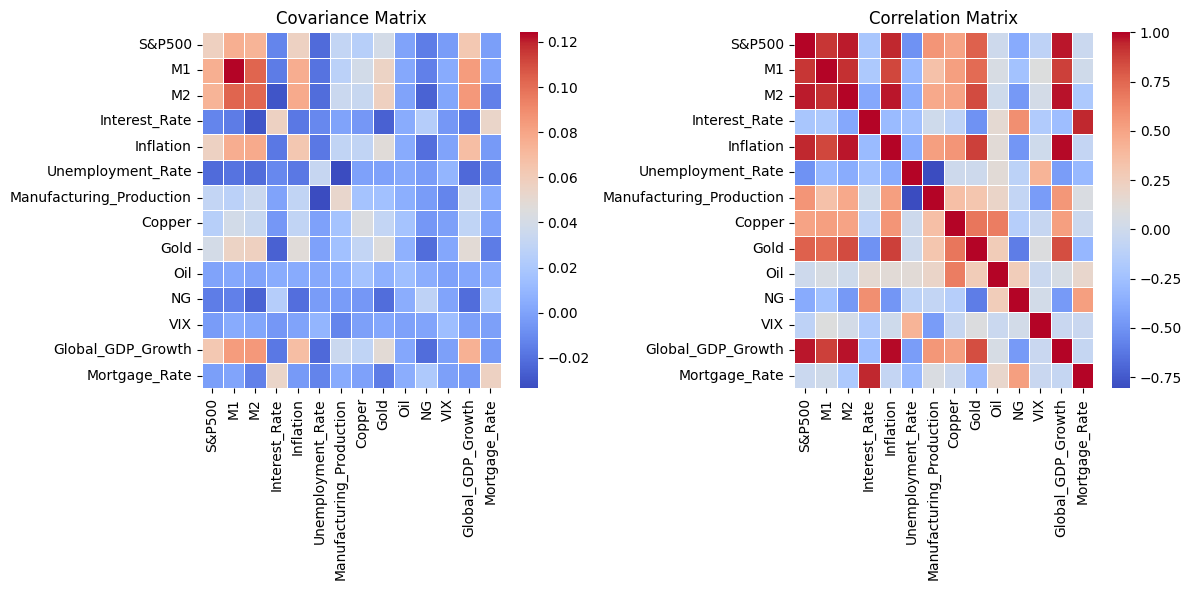

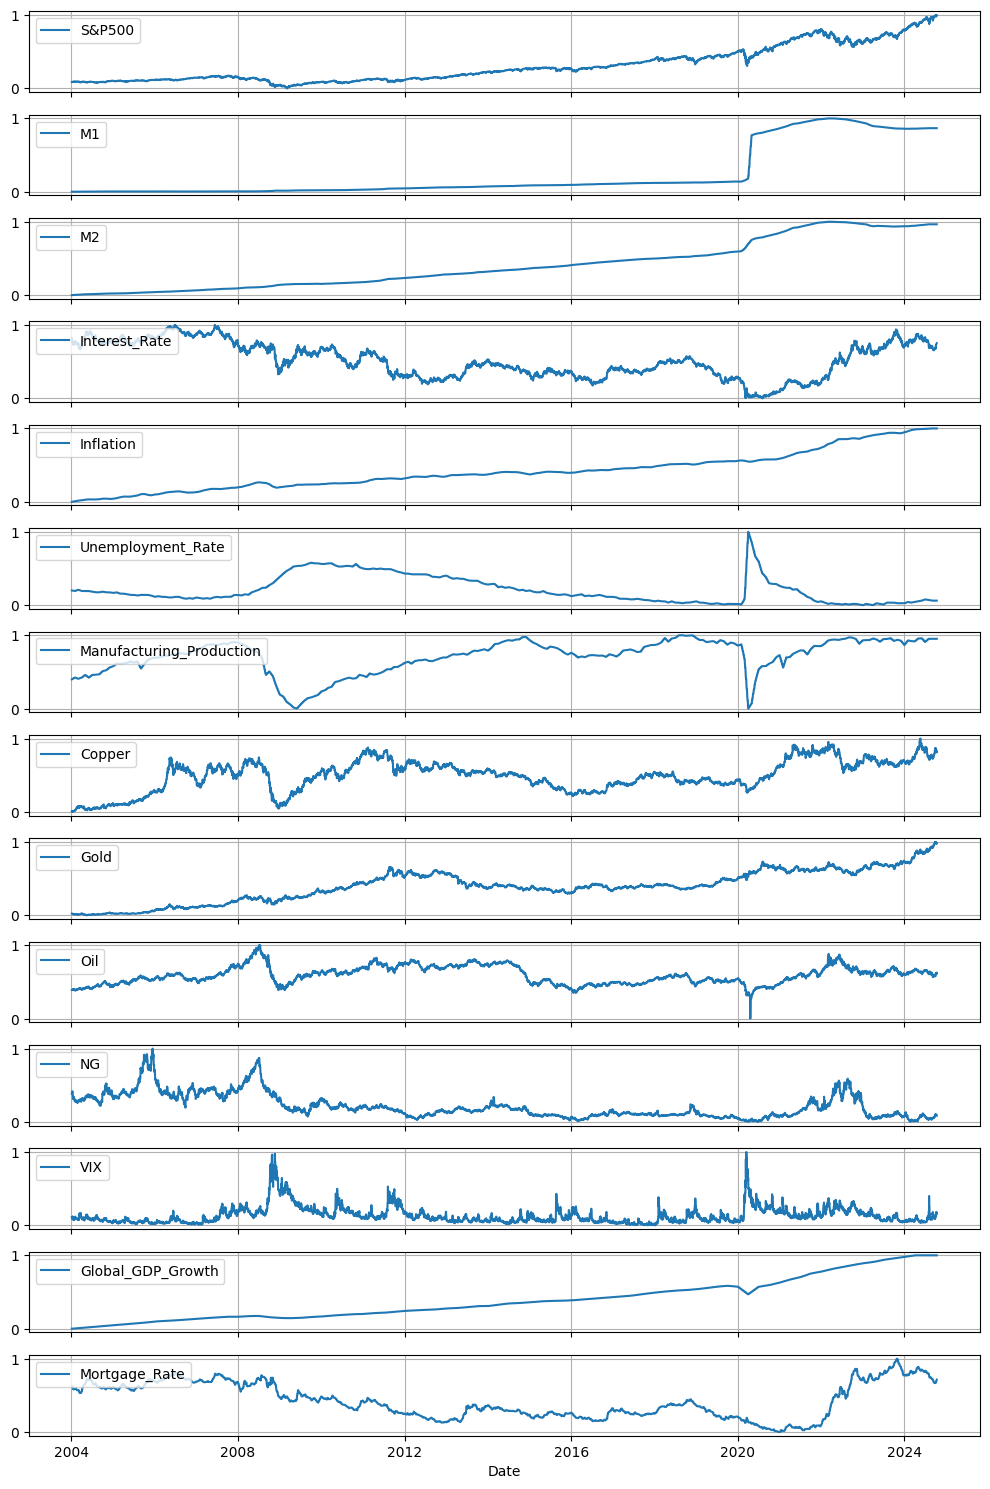

In [126]:
# --- Covariance and Correlation Matrices ---
cov_matrix = normalized_data.cov()  # Covariance matrix
corr_matrix = normalized_data.corr()  # Correlation matrix

# --- Plot Covariance and Correlation Heatmaps (without annotations) ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cov_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Covariance Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

# --- Subplots for Normalized Variables ---
variables = normalized_data.columns  

# Create subplots with the first being S&P 500
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 15), sharex=True)

# Plot each variable in a separate subplot
for i, variable in enumerate(variables):
    axes[i].plot(normalized_data.index, normalized_data[variable], label=variable)
    #axes[i].set_ylabel(variable)
    axes[i].legend(loc='upper left')
    axes[i].grid()

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

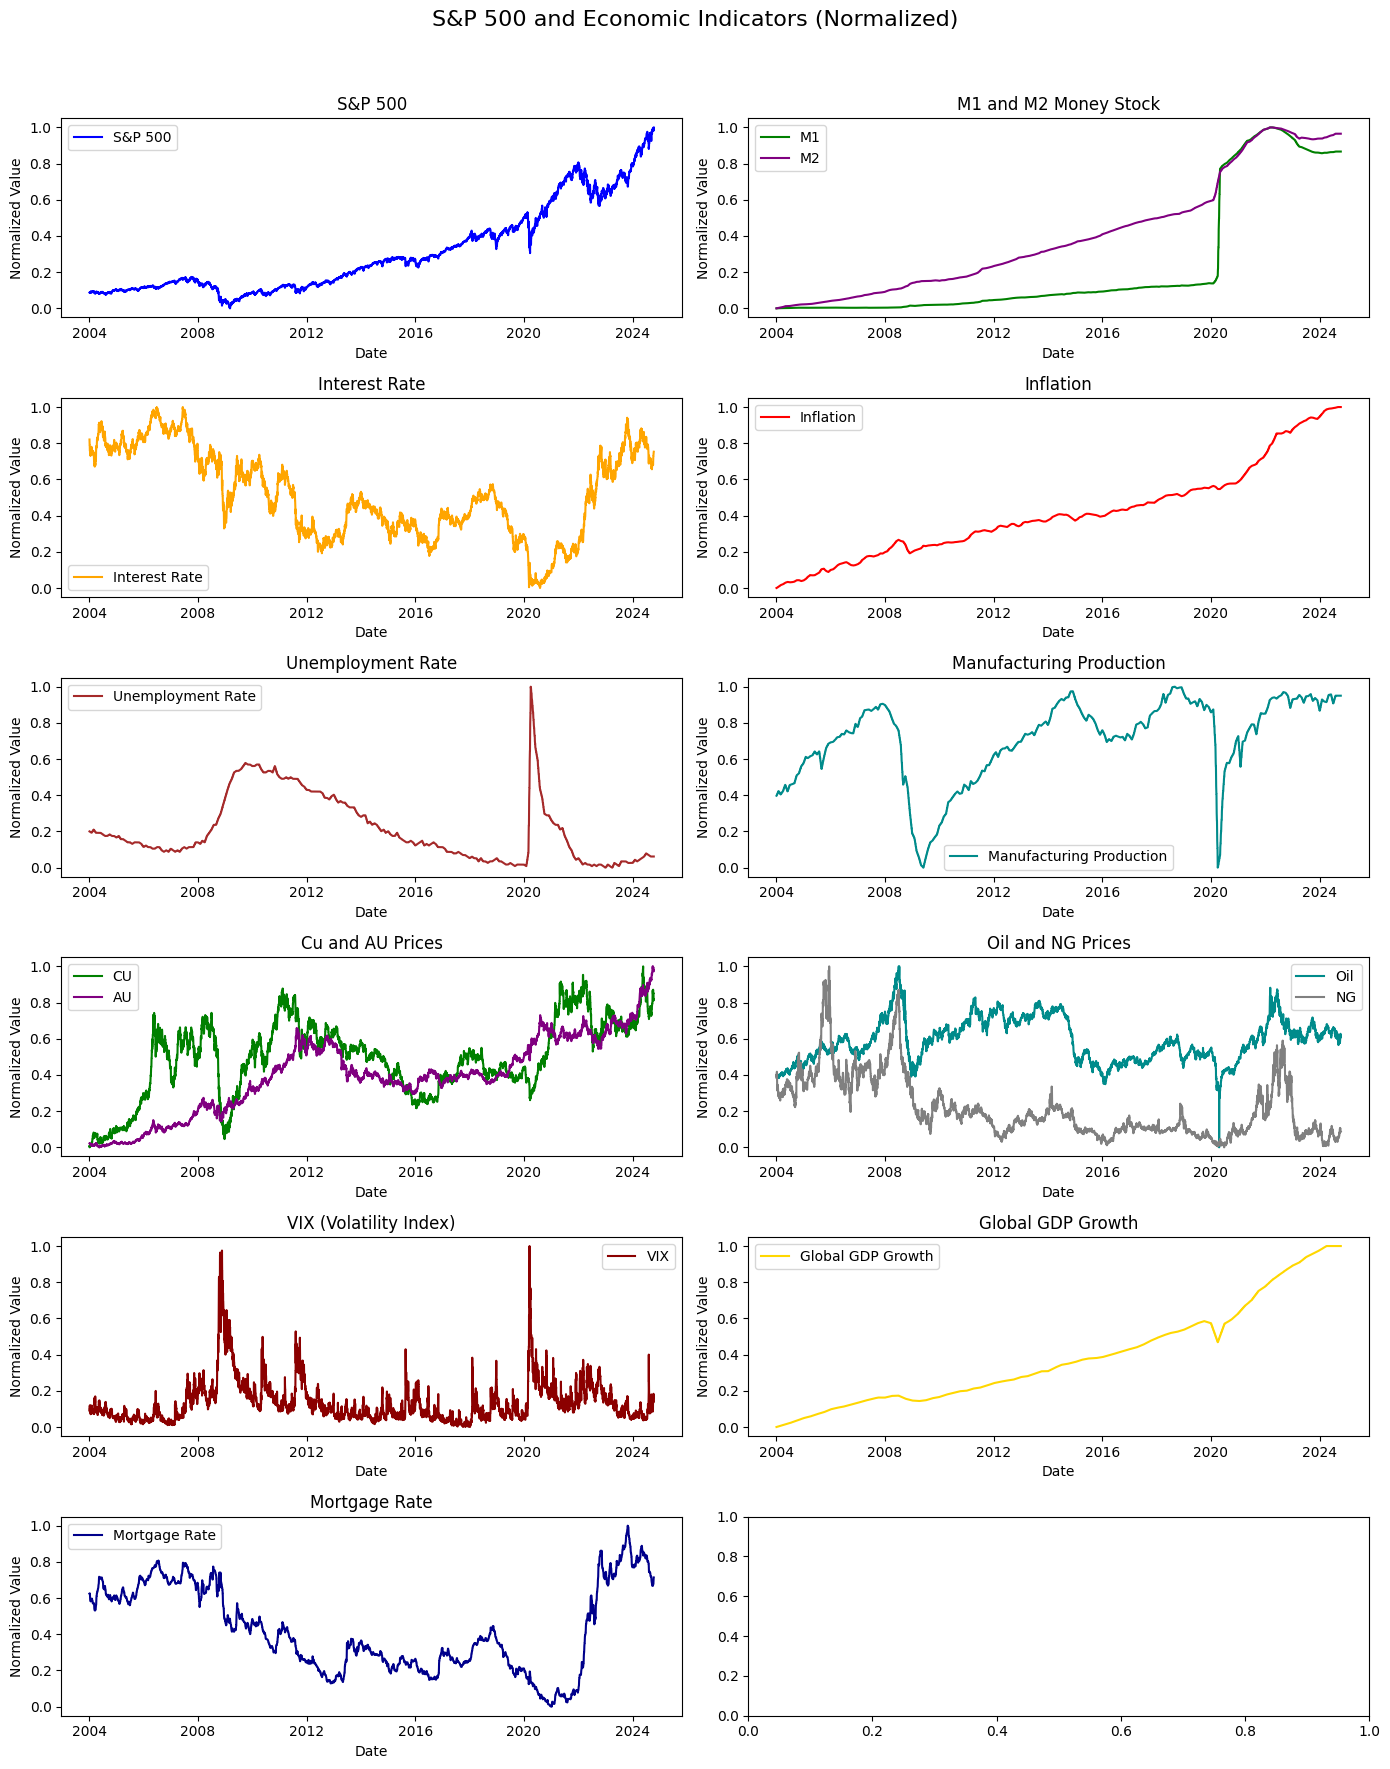

In [127]:
# Create a figure with subplots
fig, axes = plt.subplots(6, 2, figsize=(14, 18))  # 6 rows, 2 columns of subplots
fig.suptitle('S&P 500 and Economic Indicators (Normalized)', fontsize=16)

# 1) Plot S&P 500 on the first subplot
axes[0, 0].plot(normalized_data.index, normalized_data['S&P500'], label='S&P 500', color='blue')
axes[0, 0].set_title('S&P 500')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Normalized Value')
axes[0, 0].legend()

# 2) Plot M1 and M2 on the second subplot
axes[0, 1].plot(normalized_data.index, normalized_data['M1'], label='M1', color='green')
axes[0, 1].plot(normalized_data.index, normalized_data['M2'], label='M2', color='purple')
axes[0, 1].set_title('M1 and M2 Money Stock')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Normalized Value')
axes[0, 1].legend()

# 3) Plot Interest Rate on the third subplot
axes[1, 0].plot(normalized_data.index, normalized_data['Interest_Rate'], label='Interest Rate', color='orange')
axes[1, 0].set_title('Interest Rate')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Normalized Value')
axes[1, 0].legend()

# 4) Plot Inflation on the fourth subplot
axes[1, 1].plot(normalized_data.index, normalized_data['Inflation'], label='Inflation', color='red')
axes[1, 1].set_title('Inflation')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Normalized Value')
axes[1, 1].legend()

# 5) Plot Unemployment Rate on the fifth subplot
axes[2, 0].plot(normalized_data.index, normalized_data['Unemployment_Rate'], label='Unemployment Rate', color='brown')
axes[2, 0].set_title('Unemployment Rate')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Normalized Value')
axes[2, 0].legend()

# 6) Plot Manufacturing Production on the sixth subplot
axes[2, 1].plot(normalized_data.index, normalized_data['Manufacturing_Production'], label='Manufacturing Production', color='darkcyan')
axes[2, 1].set_title('Manufacturing Production')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Normalized Value')
axes[2, 1].legend()

# 7) Plot Copper and Gold on the seventh subplot
axes[3, 0].plot(normalized_data.index, normalized_data['Copper'], label='CU', color='green')
axes[3, 0].plot(normalized_data.index, normalized_data['Gold'], label='AU', color='purple')
axes[3, 0].set_title('Cu and AU Prices')
axes[3, 0].set_xlabel('Date')
axes[3, 0].set_ylabel('Normalized Value')
axes[3, 0].legend()

# 8) Plot Oil Prices on the eigth subplot
axes[3, 1].plot(normalized_data.index, normalized_data['Oil'], label='Oil', color='darkcyan')
axes[3, 1].plot(normalized_data.index, normalized_data['NG'], label='NG', color='grey')
axes[3, 1].set_title('Oil and NG Prices')
axes[3, 1].set_xlabel('Date')
axes[3, 1].set_ylabel('Normalized Value')
axes[3, 1].legend()

# 9) Plot VIX on the ninth subplot
axes[4, 0].plot(normalized_data.index, normalized_data['VIX'], label='VIX', color='darkred')
axes[4, 0].set_title('VIX (Volatility Index)')
axes[4, 0].set_xlabel('Date')
axes[4, 0].set_ylabel('Normalized Value')
axes[4, 0].legend()

# 10) Plot Global GDP Growth on the tenth subplot
axes[4, 1].plot(normalized_data.index, normalized_data['Global_GDP_Growth'], label='Global GDP Growth', color='gold')
axes[4, 1].set_title('Global GDP Growth')
axes[4, 1].set_xlabel('Date')
axes[4, 1].set_ylabel('Normalized Value')
axes[4, 1].legend()

# 11) Plot Mortgage Rate on the eleventh subplot
axes[5, 0].plot(normalized_data.index, normalized_data['Mortgage_Rate'], label='Mortgage Rate', color='darkblue')
axes[5, 0].set_title('Mortgage Rate')
axes[5, 0].set_xlabel('Date')
axes[5, 0].set_ylabel('Normalized Value')
axes[5, 0].legend()


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusts the layout to fit everything within the figure
plt.show()

When building a leading indicator to predict a target variable (such as the S&P 500), you typically want to select variables based on their relationship with the target variable.

### 1. **High Correlation and Covariance:**
   - **Correlation**: You generally want to **pick variables that exhibit a high positive or negative correlation** with the target variable. High positive correlation suggests that as the leading indicator increases, the target variable also tends to increase, while high negative correlation indicates an inverse relationship.
   - **Covariance**: A high covariance between a leading indicator and the target variable indicates that the two variables tend to move together (in the same direction). Positive covariance suggests that increases in the leading indicator are associated with increases in the target variable, while negative covariance suggests the opposite.

### 2. **Leading Indicators:**
   - **Predictive Power**: Leading indicators are typically variables that can provide early signals about future movements in the target variable. They should ideally change before the target variable responds, allowing you to anticipate changes.
   - **Economic Theory**: Economic and financial theories often inform which indicators may be leading. For example, consumer confidence may precede changes in economic growth, and certain commodity prices might precede stock market movements.

### 3. **Modeling Considerations:**
   - **Multicollinearity**: Be cautious of multicollinearity, which occurs when two or more independent variables are highly correlated. This can complicate interpretation and may reduce the reliability of the regression coefficients.
   - **Lagged Effects**: Leading indicators often require lagged values to capture the delayed effect on the target variable. This means you may need to analyze how past values of the leading indicator correlate with future values of the target variable.

### 4. **Evaluating Relationships:**
   - **Correlation Matrix**: Use a correlation matrix to assess the relationship between potential leading indicators and the target variable. Select variables that have significant correlations.
   - **Feature Selection Techniques**: Employ statistical techniques such as PCA (Principal Component Analysis), forward selection, or regularization methods (like Lasso or Ridge regression) to help determine which variables contribute the most predictive power.

Here’s a breakdown of potential time series to use as leading indicators for each lead time:

### 1. **5-Day Lead Indicators:**
   - **Consumer Confidence Index (CCI)**: This reflects consumers' perceptions of the economy and can change rapidly, offering short-term predictive signals.
   - **Weekly Jobless Claims**: Changes in unemployment claims can be an immediate signal of economic shifts and consumer behavior.
   - **Stock Market Volatility (VIX)**: A spike in volatility can precede declines in stock prices, providing a short-term warning.
   - **Weekly Retail Sales**: Provides timely insights into consumer spending trends that can impact stock prices shortly after.
   - **Interest Rate Changes**: Short-term movements in rates can affect market sentiment almost immediately.

### 2. **20-Day Lead Indicators:**
   - **M1 and M2 Money Supply**: Changes in the money supply can indicate shifts in economic activity, potentially leading to market changes in weeks.
   - **Leading Economic Index (LEI)**: This index aggregates several economic indicators and is designed to predict economic activity over the next few months.
   - **Commodity Prices (e.g., Oil, Gold)**: Changes in commodity prices can indicate shifts in economic conditions, impacting markets within weeks.
   - **Manufacturing and Services PMIs**: Purchasing Managers’ Indices provide timely data on business sentiment and can lead stock market movements.
   - **Consumer Spending Reports**: Insights into consumer behavior can signal changes in economic trends.

### 3. **60-Day Lead Indicators:**
   - **Global GDP Growth Rates**: Changes in global economic conditions can affect the U.S. market, with a lag of about two months.
   - **Corporate Earnings Reports**: Quarterly earnings reports can indicate trends that will influence stock prices in the following months.
   - **Interest Rate Trends**: Long-term interest rate changes (e.g., Federal Reserve policies) can affect market sentiment over a longer lead time.
   - **Housing Market Data**: Metrics such as housing starts and building permits can provide insights into economic conditions that influence the stock market over the next couple of months.
   - **Stock Market Breadth Indicators**: Measures of how many stocks are participating in a rally or decline can signal future movements in broader market indices.

In [128]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the combined data (S&P 500 and economic indicators)
normalized_data_w_snp = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns, index=combined_data.index)

# Exclude the S&P 500 and take the mean across all other columns
combined_series = normalized_data_w_snp.drop(columns=['S&P500']).mean(axis=1)

# Extract the normalized S&P 500 separately
normalized_snp = normalized_data_w_snp['S&P500']

# Drop S&P 500
normalized_data_no_snp = normalized_data_w_snp.drop(columns=['S&P500'])

# Align the starting values of both series
combined_series_aligned = combined_series * (normalized_snp.iloc[0] / combined_series.iloc[0])

In [129]:
normalized_data_no_snp.tail()

,M1,M2,Interest_Rate,Inflation,Unemployment_Rate,Manufacturing_Production,Copper,Gold,Oil,NG,VIX,Global_GDP_Growth,Mortgage_Rate
2024-10-07,0.866465,0.965023,0.740506,1.0,0.061704,0.950409,0.852089,0.989064,0.627433,0.090961,0.183549,1.0,0.697332
2024-10-08,0.866465,0.965023,0.742616,1.0,0.061704,0.950409,0.825712,0.976080,0.607916,0.090026,0.166961,1.0,0.702890
2024-10-09,0.866465,0.965023,0.746835,1.0,0.061704,0.950409,0.811660,0.972158,0.606112,0.084773,0.159347,1.0,0.708449
2024-10-10,0.866465,0.965023,0.753165,1.0,0.061704,0.950409,0.819056,0.978520,0.620381,0.085852,0.160299,1.0,0.714008
2024-10-11,0.866465,0.965023,0.753165,1.0,0.061704,0.950409,0.819056,0.978520,0.620381,0.085852,0.160299,1.0,0.714008


### How do i find the best combination of data series to fit the SnP?

To test different combinations of data for the `combined_series` and find the best fit to the S&P 500 (normalized S&P 500), you can follow these steps:

1. **Define subsets of variables**: You can generate different combinations of the features (economic indicators and commodity prices) and compute a combined series for each combination.
   
2. **Evaluate the fit**: For each combination, compare the combined series with the normalized S&P 500. You can use a metric like the **R-squared (R²)** score or **mean squared error (MSE)** to evaluate how well the combined series fits the S&P 500.

3. **Select the best combination**: After evaluating all combinations, select the one that provides the best fit (highest R² score or lowest MSE).

### Explanation:

1. **Generating Combinations**: We use `itertools.combinations()` to generate different combinations of variables from the economic and commodity data.
   
2. **Evaluate Fit**: For each combination of variables, we calculate the **R² score** and **MSE** between the combined series (mean of selected variables) and the normalized S&P 500. The higher the R² score (closer to 1), the better the fit.

3. **Best Fit Selection**: We track the combination that produces the highest R² score and lowest MSE and plot it alongside the normalized S&P 500.

### Output:
- **Best Combination of Variables**: This will show which combination of features provides the best fit for the S&P 500.
- **Plot**: The plot will show the best-fitting combination’s behavior compared to the S&P 500.

This way, you can systematically test different combinations of data and find which combination explains the S&P 500 the best.

In [130]:
### Make some new DF

# Copy of the Original DF
data_w_snp = combined_data

# Extract the S&P 500 separately
snp = data_w_snp['S&P500']

# Drop S&P 500
data_no_snp = data_w_snp.drop(columns=['S&P500'])

Best combination of variables: ('M1', 'M2', 'Inflation', 'NG', 'Global_GDP_Growth')
Best R-squared score: 0.9138764779206582
Best Mean Squared Error: 0.0049215482888706275
Worst combination of variables: ('Manufacturing_Production',)
Worst R-squared score: -2.6548305778613783

All combinations tested (sorted by R²):
                                           Combination        R²       MSE
1168        (M1, M2, Inflation, NG, Global_GDP_Growth)  0.913876  0.004922
427                    (M1, M2, NG, Global_GDP_Growth)  0.902001  0.005600
1170       (M1, M2, Inflation, VIX, Global_GDP_Growth)  0.901087  0.005652
1242             (M1, M2, Gold, NG, Global_GDP_Growth)  0.893797  0.006069
2568  (M1, M2, Inflation, Gold, NG, Global_GDP_Growth)  0.892813  0.006125
...                                                ...       ...       ...
8                                               (Oil,) -1.648930  0.151374
38           (Interest_Rate, Manufacturing_Production) -1.761955  0.157833
65     

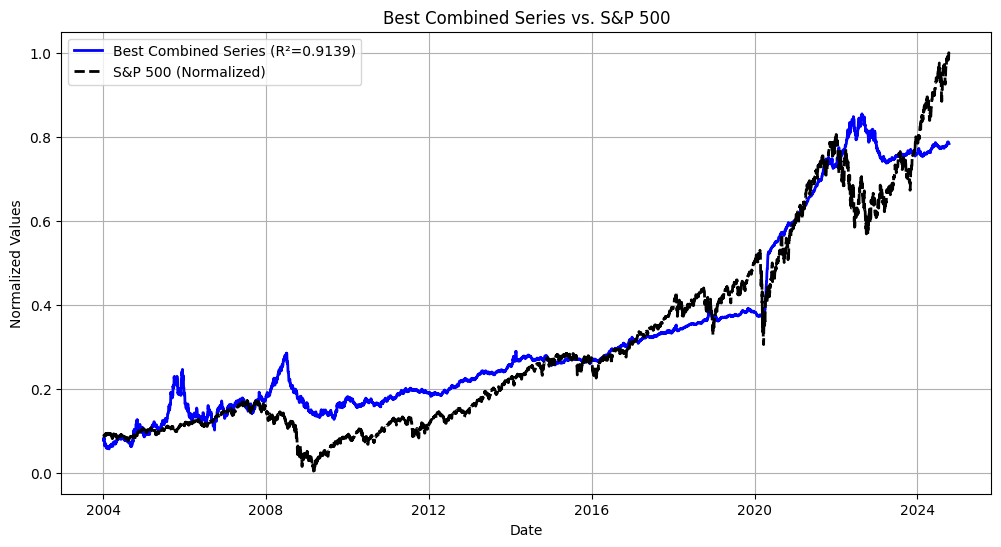

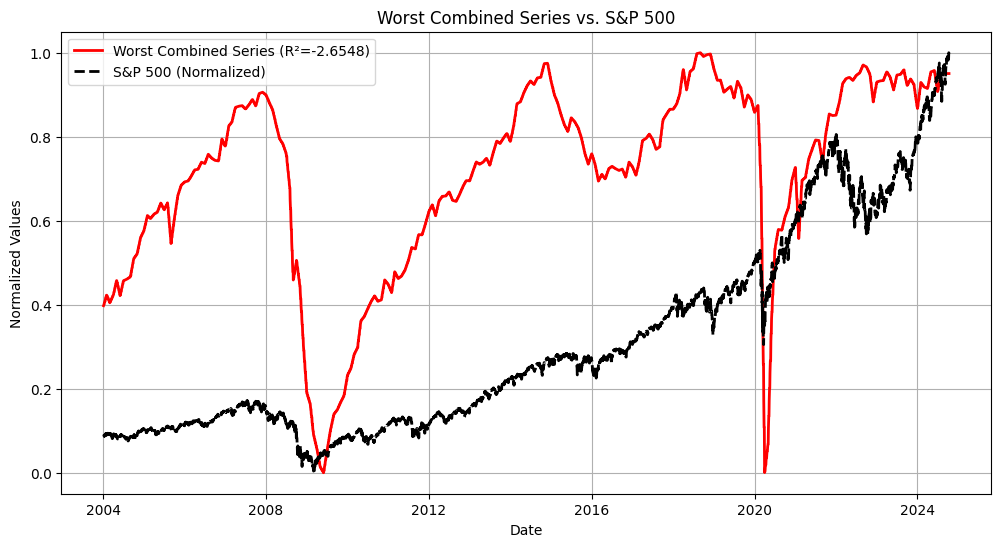

In [131]:
# Normalize the original combined data (S&P 500 and economic indicators)
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data_w_snp), 
                               columns=data_w_snp.columns, index=data_w_snp.index)
normalized_data_no_snp = pd.DataFrame(scaler.fit_transform(data_no_snp), 
                               columns=data_no_snp.columns, index=data_no_snp.index)

# Extract the normalized S&P 500 separately
normalized_snp = normalized_data['S&P500']

# Get the independent variables
variables = normalized_data_no_snp

# Function to evaluate the fit of a given combination of variables
def evaluate_combination(selected_columns):
    # Combine the selected variables (mean of the selected columns)
    combined_series = normalized_data_no_snp[selected_columns].mean(axis=1)
    
    # Calculate R-squared score and MSE for the fit to S&P 500
    r2 = r2_score(normalized_snp, combined_series)
    mse = mean_squared_error(normalized_snp, combined_series)
    
    return r2, mse, combined_series

# Prepare a list to store all combinations and their metrics
all_combinations = []

# Initialize variables to track the best and worst combinations
best_combination = None
best_r2 = -np.inf  # Initialize with a very low R²
best_mse = np.inf  # Initialize with a very high MSE
best_series = None

worst_combination = None
worst_r2 = np.inf  # Initialize with a very high R² (will be minimized)
worst_series = None

# Iterate over different combinations of variables
for i in range(1, len(variables) + 1):
    for combination in itertools.combinations(variables, i):
        r2, mse, combined_series = evaluate_combination(list(combination))
        
        # Store each combination's metrics
        all_combinations.append((combination, r2, mse))

        # Update if the current combination is better
        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_combination = combination
            best_series = combined_series

        # Update if the current combination is worse
        if r2 < worst_r2:
            worst_r2 = r2
            worst_combination = combination
            worst_series = combined_series

# Output the best and worst combination and their fit metrics
print(f"Best combination of variables: {best_combination}")
print(f"Best R-squared score: {best_r2}")
print(f"Best Mean Squared Error: {best_mse}")
print(f"Worst combination of variables: {worst_combination}")
print(f"Worst R-squared score: {worst_r2}")

# Convert all_combinations to a DataFrame for sorting
combination_df = pd.DataFrame(all_combinations, columns=['Combination', 'R²', 'MSE'])

# Sort by R² in descending order
combination_df.sort_values(by='R²', ascending=False, inplace=True)

# Print out all combinations tested with their R² and MSE, sorted by R²
print("\nAll combinations tested (sorted by R²):")
print(combination_df)

# Plot the best combined series against the normalized S&P 500
plt.figure(figsize=(12, 6))
plt.plot(best_series.index, best_series, label=f'Best Combined Series (R²={best_r2:.4f})', color='blue', linewidth=2)
plt.plot(normalized_snp.index, normalized_snp, label='S&P 500 (Normalized)', color='black', linestyle='--', linewidth=2)
plt.title('Best Combined Series vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot the worst combined series against the normalized S&P 500
plt.figure(figsize=(12, 6))
plt.plot(worst_series.index, worst_series, label=f'Worst Combined Series (R²={worst_r2:.4f})', color='red', linewidth=2)
plt.plot(normalized_snp.index, normalized_snp, label='S&P 500 (Normalized)', color='black', linestyle='--', linewidth=2)
plt.title('Worst Combined Series vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.show()

### Find the best 5 combinations

In [132]:
# Function to evaluate the fit of a given combination of variables
def evaluate_combination(selected_columns):
    # Combine the selected variables (mean of the selected columns)
    combined_series = normalized_data_no_snp[selected_columns].mean(axis=1)
    
    # Calculate R-squared score and MSE for the fit to S&P 500
    r2 = r2_score(normalized_snp, combined_series)
    mse = mean_squared_error(normalized_snp, combined_series)

    # Calculate AIC and BIC
    n = len(normalized_snp)  # Number of observations
    residuals = normalized_snp - combined_series
    rss = np.sum(residuals**2)  # Residual Sum of Squares
    k = len(selected_columns)  # Number of predictors

    # AIC and BIC calculations
    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)

    return r2, mse, aic, bic, combined_series

# List to store the top 5 combinations and their results
top_combinations = []

# Iterate over different combinations of variables
for i in range(1, len(variables) + 1):
    for combination in itertools.combinations(variables, i):
        r2, mse, aic, bic, combined_series = evaluate_combination(list(combination))
        
        # Append the result to the list
        top_combinations.append((r2, mse, aic, bic, combination, combined_series))

# Sort by R² score and keep top 5
top_combinations = sorted(top_combinations, key=lambda x: x[0], reverse=True)[:5]

# Output the top 5 combinations and their fit metrics
for i, (r2, mse, aic, bic, combination, _) in enumerate(top_combinations, 1):
    print(f"Combination {i}: {combination}")
    print(f"  R-squared score: {r2:.4f}")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  AIC: {aic:.4f}")
    print(f"  BIC: {bic:.4f}\n")

Combination 1: ('M1', 'M2', 'Inflation', 'NG', 'Global_GDP_Growth')
  R-squared score: 0.9139
  Mean Squared Error: 0.0049
  AIC: -40303.0061
  BIC: -40268.3359

Combination 2: ('M1', 'M2', 'NG', 'Global_GDP_Growth')
  R-squared score: 0.9020
  Mean Squared Error: 0.0056
  AIC: -39325.0665
  BIC: -39297.3303

Combination 3: ('M1', 'M2', 'Inflation', 'VIX', 'Global_GDP_Growth')
  R-squared score: 0.9011
  Mean Squared Error: 0.0057
  AIC: -39252.6354
  BIC: -39217.9651

Combination 4: ('M1', 'M2', 'Gold', 'NG', 'Global_GDP_Growth')
  R-squared score: 0.8938
  Mean Squared Error: 0.0061
  AIC: -38713.2062
  BIC: -38678.5359

Combination 5: ('M1', 'M2', 'Inflation', 'Gold', 'NG', 'Global_GDP_Growth')
  R-squared score: 0.8928
  Mean Squared Error: 0.0061
  AIC: -38641.2471
  BIC: -38599.6427



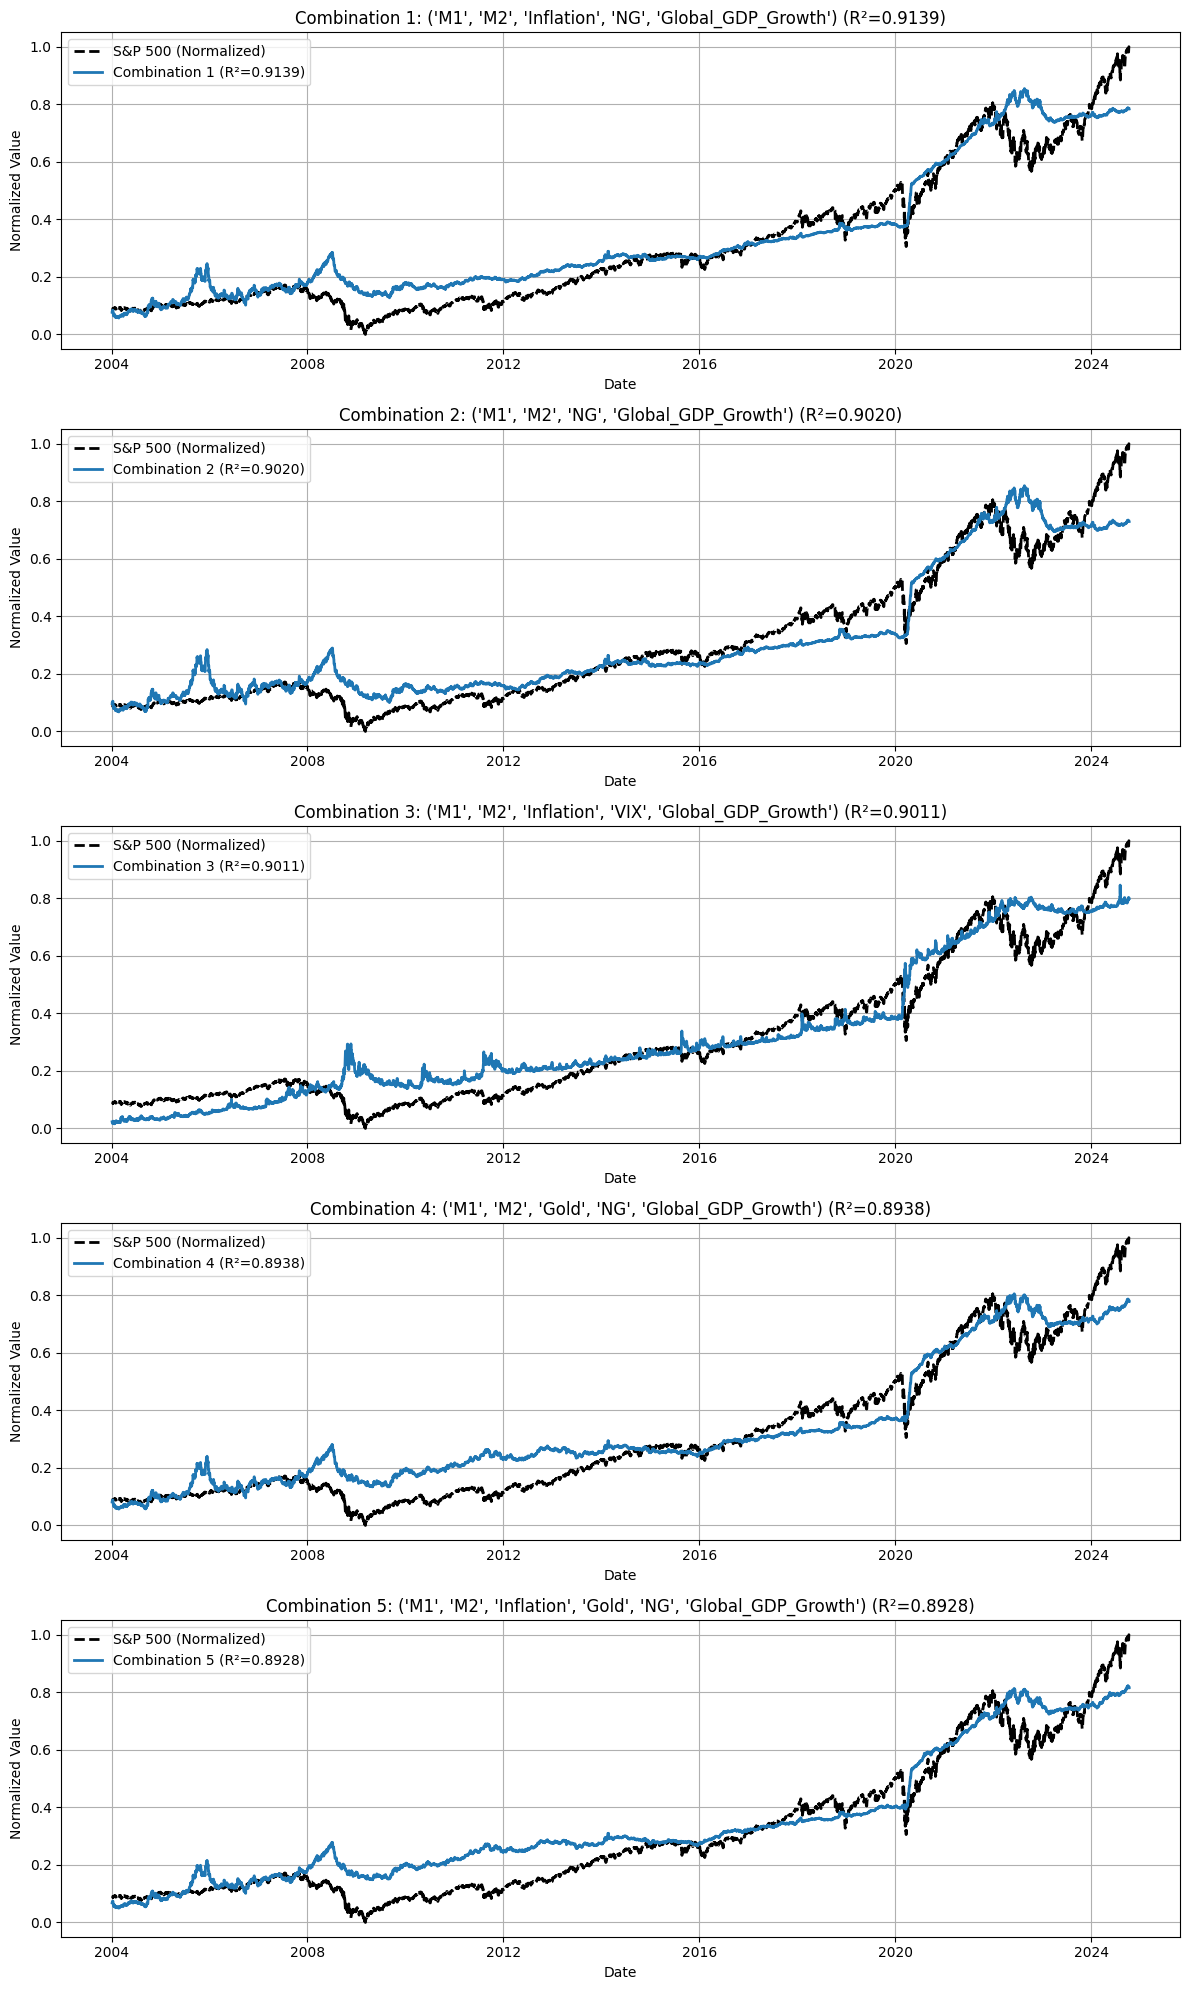

In [133]:
# --- Create subplots ---
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))

# Ensure axes is always treated as a list
if not isinstance(axes, np.ndarray):
    axes = [axes]

# Plot the top 5 combinations with S&P 500 in each subplot
for i, (r2, _, _, _, combination, combined_series) in enumerate(top_combinations):
    # Plot normalized S&P 500 for reference in each subplot
    axes[i].plot(normalized_snp.index, normalized_snp, label='S&P 500 (Normalized)', color='black', linestyle='--', linewidth=2)
    
    # Plot the combined series for the current combination
    axes[i].plot(combined_series.index, combined_series, label=f'Combination {i+1} (R²={r2:.4f})', linewidth=2)
    
    # Add title and labels to each subplot
    axes[i].set_title(f'Combination {i+1}: {combination} (R²={r2:.4f})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Normalized Value')
    axes[i].legend(loc='best')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Check the variables to see which combination is the best leading indicator for the S&P

Top combinations by R²:
                                            Combination        R²       MSE
8190  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974823  0.001439
8185  (M1, M2, Interest_Rate, Inflation, Manufacturi...  0.974822  0.001439
8183  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974818  0.001440
8133  (M1, M2, Interest_Rate, Inflation, Manufacturi...  0.974815  0.001440
8181  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974802  0.001440


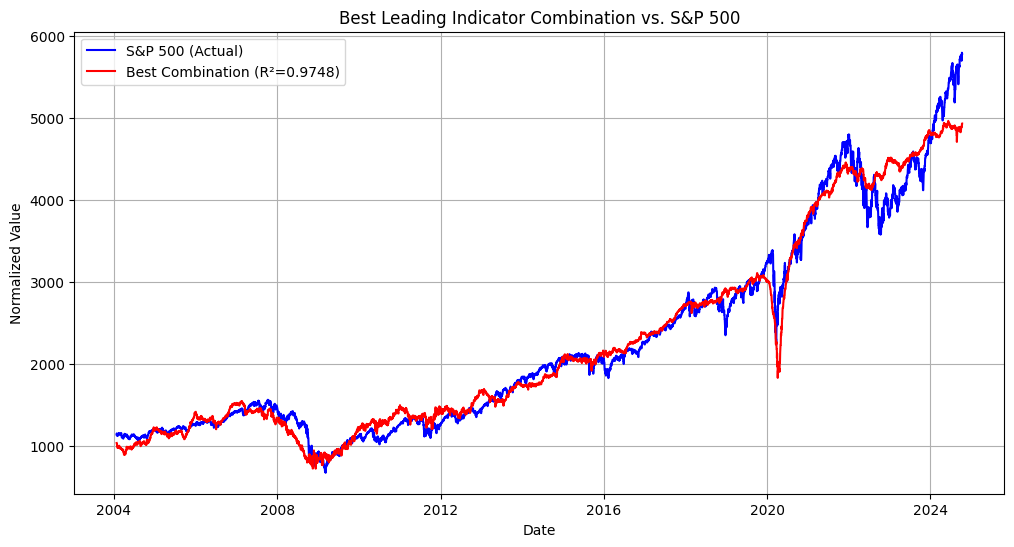

In [134]:
### Test different combinations of variables ###

# Prepare the data
X = combined_data.drop(columns=['S&P500'])  # Independent variables (exclude S&P 500)
y = combined_data['S&P500']  # Dependent variable (S&P 500)

# Lag the independent variables to create leading indicators
lag = 20  
X_lagged = X.shift(lag).dropna()  

# Align S&P 500 with lagged variables (shift y forward by the lag to match)
y_lagged = y.loc[X_lagged.index]

# Normalize the data
#scaler = MinMaxScaler()
X_lagged_scaled = pd.DataFrame(scaler.fit_transform(X_lagged), columns=X_lagged.columns, index=X_lagged.index)
y_lagged_scaled = scaler.fit_transform(y_lagged.values.reshape(-1, 1))

# Function to evaluate the fit of a given combination of variables
def evaluate_combination(selected_columns):
    # Create regression model
    model = LinearRegression()

    # Select the columns to test
    X_comb = X_lagged_scaled[selected_columns]

    # Train the model and evaluate
    model.fit(X_comb, y_lagged_scaled)
    y_pred = model.predict(X_comb)

    # Calculate R-squared and MSE
    r2 = r2_score(y_lagged_scaled, y_pred)
    mse = mean_squared_error(y_lagged_scaled, y_pred)

    return r2, mse, y_pred

# Store all combinations' results
all_combinations = []

# Test different combinations of variables
variables = X_lagged_scaled.columns
for i in range(1, len(variables) + 1):
    for combination in itertools.combinations(variables, i):
        r2, mse, _ = evaluate_combination(list(combination))
        all_combinations.append((combination, r2, mse))

# Convert results to DataFrame and sort by R²
results_df = pd.DataFrame(all_combinations, columns=['Combination', 'R²', 'MSE'])
results_df.sort_values(by='R²', ascending=False, inplace=True)

# Print the top combinations
print("Top combinations by R²:")
print(results_df.head(5))

# Plot the best combination
best_combination = results_df.iloc[0]['Combination']
_, _, best_pred = evaluate_combination(list(best_combination))

# Convert scaled predictions back to original scale for plotting
y_lagged_inverse = scaler.inverse_transform(y_lagged_scaled).flatten()
best_pred_inverse = scaler.inverse_transform(best_pred).flatten()

# Plot the results
plt.figure(figsize=(12, 6))

# Use the actual date index for the X-axis
plt.plot(y_lagged.index, y_lagged_inverse, label='S&P 500 (Actual)', color='blue')
plt.plot(y_lagged.index, best_pred_inverse, label=f'Best Combination (R²={results_df.iloc[0]["R²"]:.4f})', color='red')

plt.title('Best Leading Indicator Combination vs. S&P 500')
plt.xlabel('Date')  # Use date for X-axis label
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
first_combination = results_df['Combination'].iloc[0]
print(first_combination)

('M1', 'M2', 'Interest_Rate', 'Inflation', 'Unemployment_Rate', 'Manufacturing_Production', 'Copper', 'Gold', 'Oil', 'NG', 'VIX', 'Global_GDP_Growth', 'Mortgage_Rate')


To perform a **sensitivity analysis** for different lags (e.g., 5, 20, 60 days), we need to modify the earlier code to loop through different lag values and evaluate each combination of variables for each lag.

### Process Overview:
1. **Loop through lag values**: Test 5-day, 20-day, and 60-day lags.
2. **Evaluate combinations**: For each lag, test all combinations of variables.
3. **Store and compare results**: Track the R² and MSE for each lag and combination.
4. **Rank by performance**: Sort by the best combinations across different lags.


Top 3 combinations tested across all lags:

Lag = 5 days:
                                            Combination        R²       MSE
8190  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974866  0.001436
8184  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974866  0.001436
8183  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974860  0.001437

Lag = 20 days:
                                            Combination        R²       MSE
8190  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974823  0.001439
8185  (M1, M2, Interest_Rate, Inflation, Manufacturi...  0.974822  0.001439
8183  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.974818  0.001440

Lag = 60 days:
                                            Combination        R²       MSE
8190  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.975471  0.001403
8183  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.975459  0.001404
8181  (M1, M2, Interest_Rate, Inflation, Unemploymen...  0.975447  0.0014

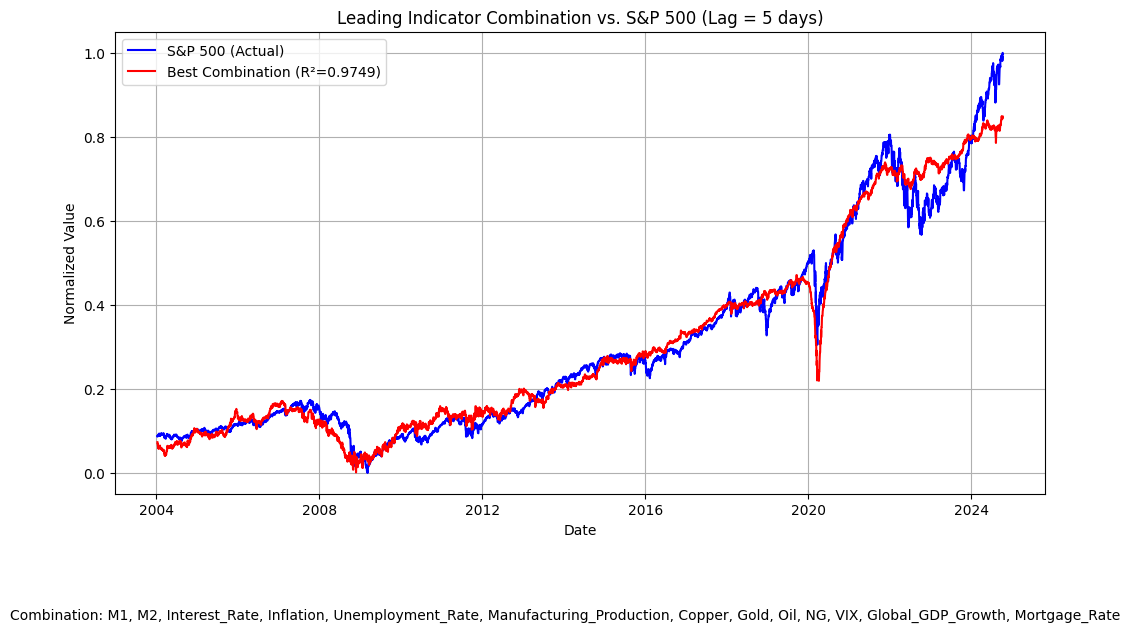

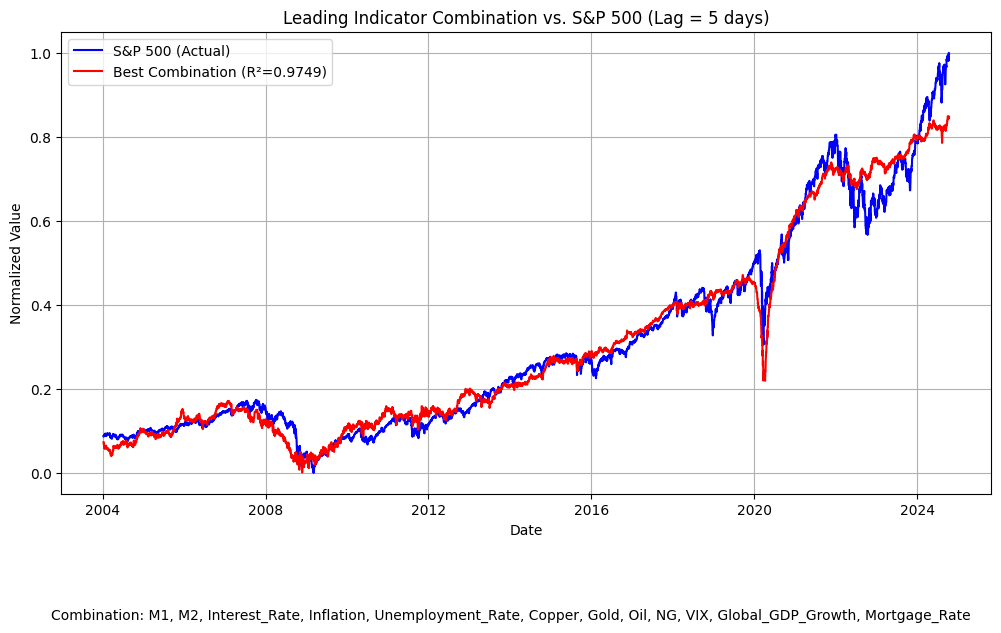

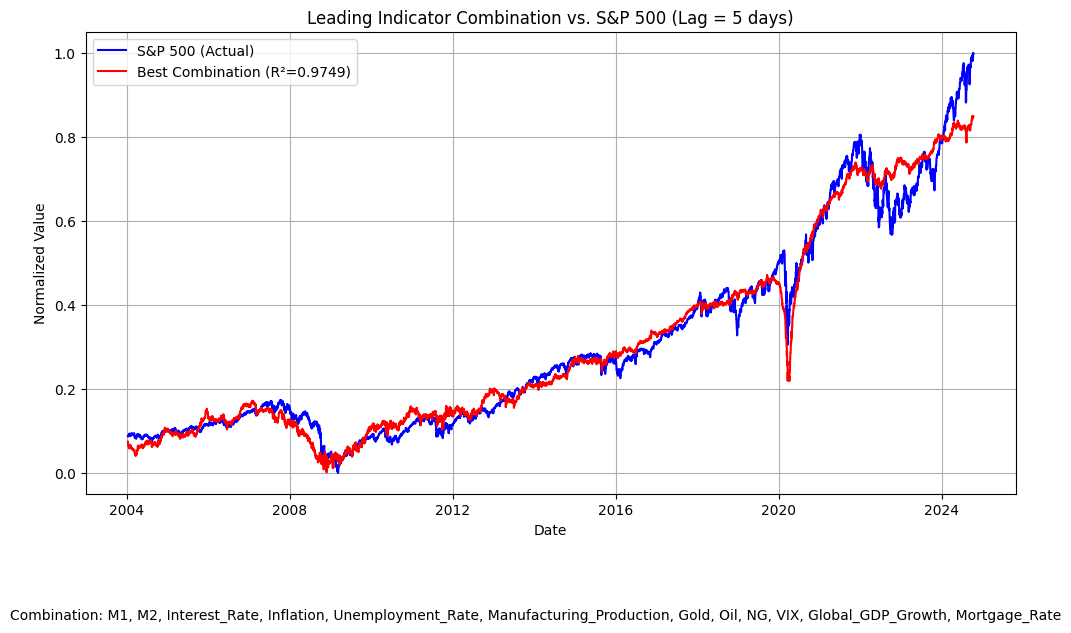

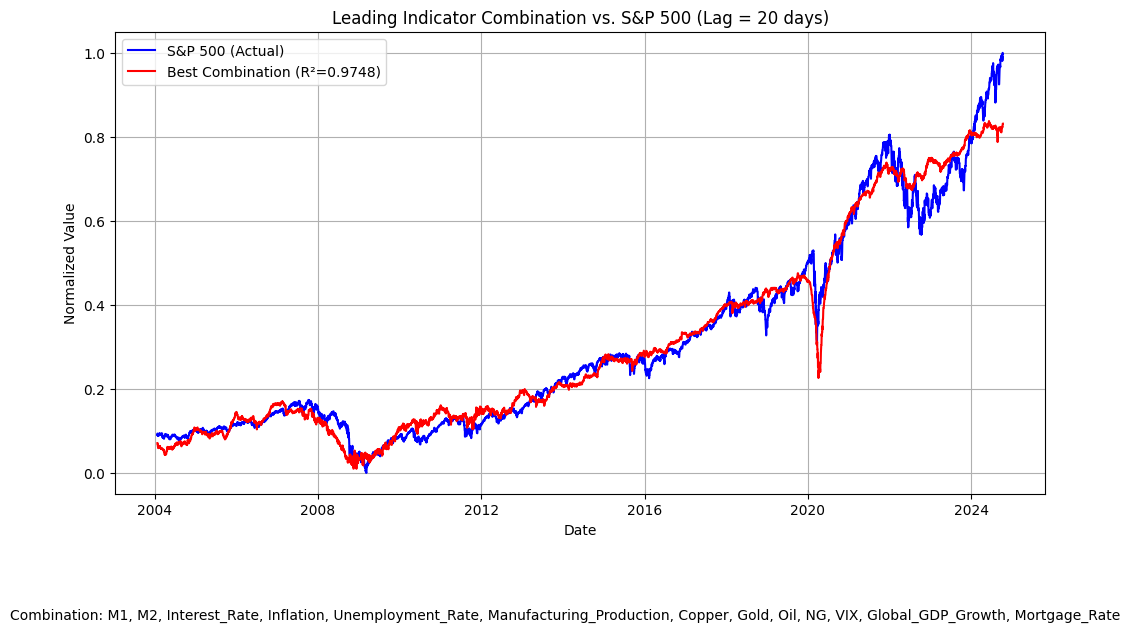

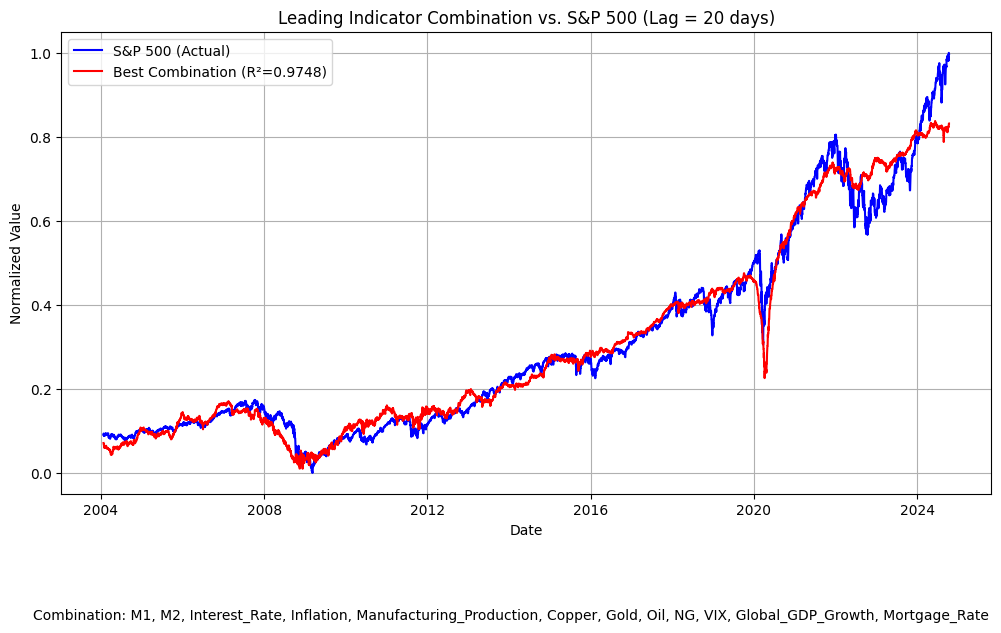

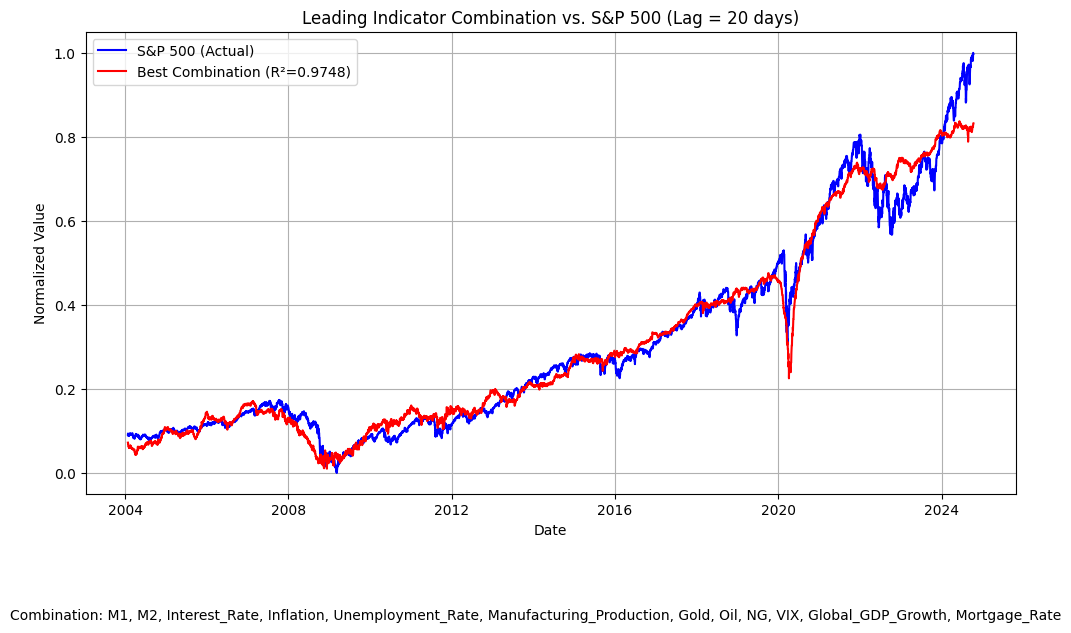

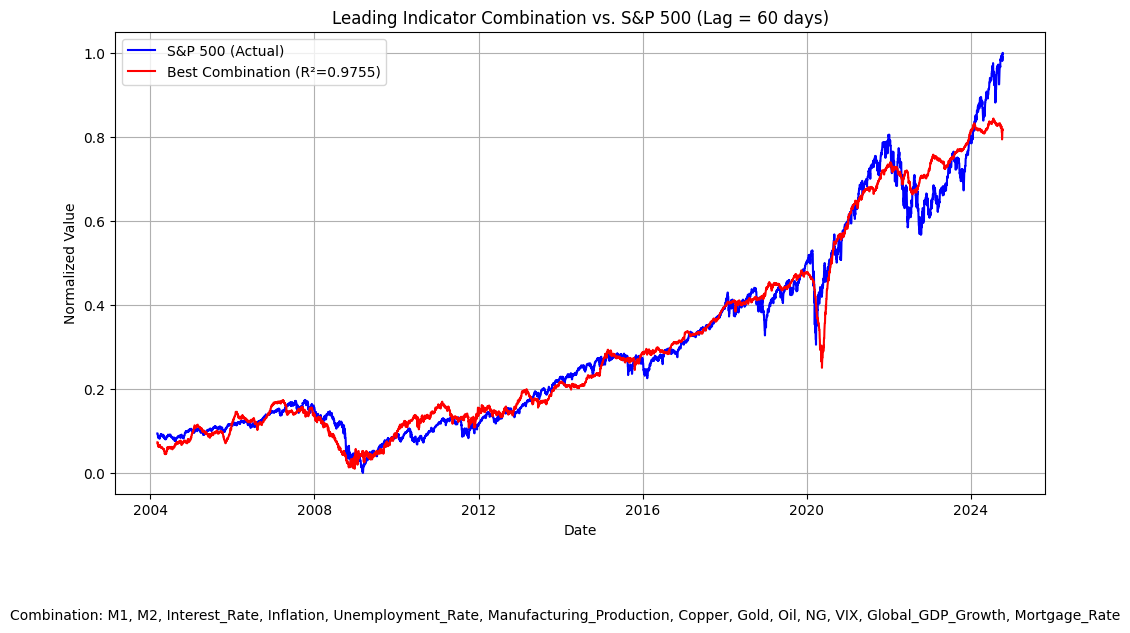

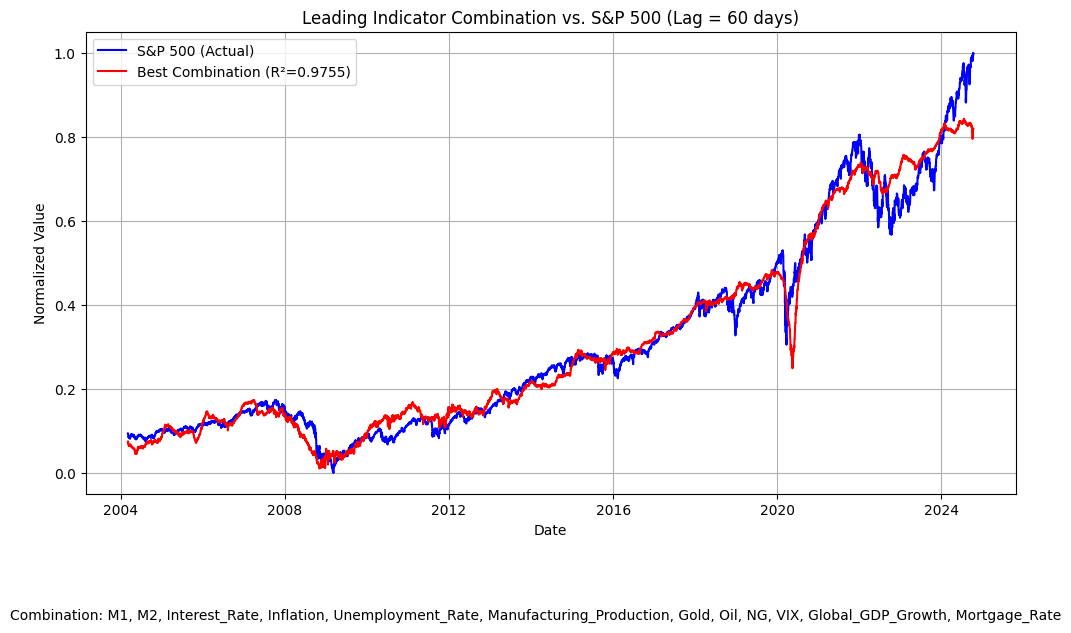

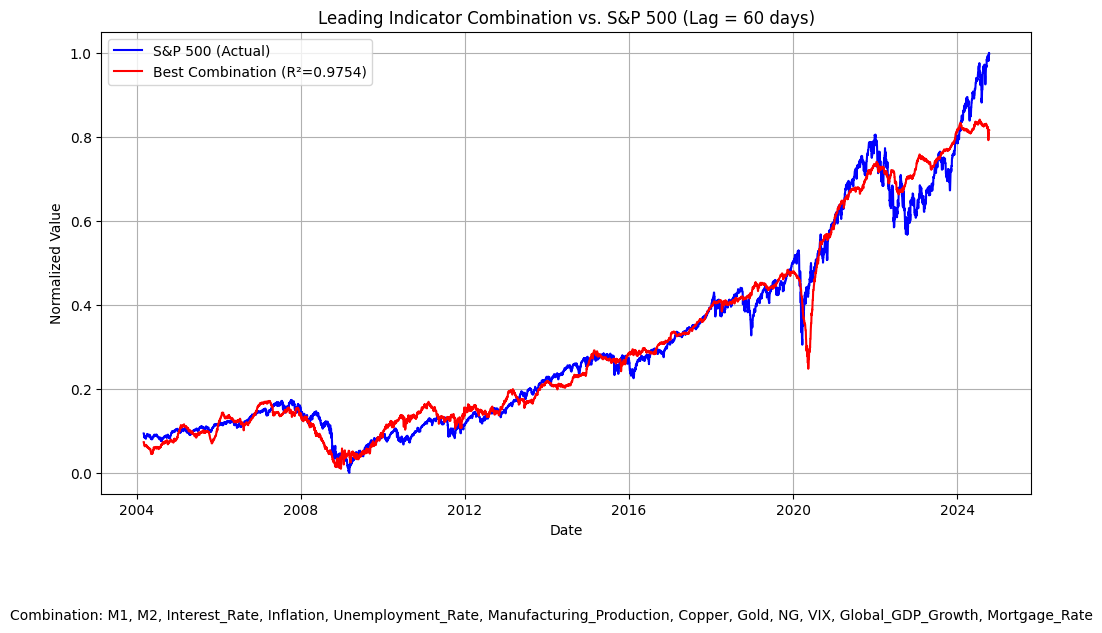

In [136]:
# Normalize the combined data (S&P 500 and economic indicators)
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns, index=combined_data.index)

# Extract the normalized S&P 500 separately
normalized_snp = normalized_data['S&P500']

# Drop the S&P 500 to get the independent variables
variables = normalized_data.drop(columns=['S&P500']).columns

# Function to evaluate the fit of a given combination of variables
def evaluate_combination(X_lagged, y_lagged, selected_columns):
    # Create regression model
    model = LinearRegression()

    # Select the columns to test
    X_comb = X_lagged[selected_columns]

    # Train the model and evaluate
    model.fit(X_comb, y_lagged)
    y_pred = model.predict(X_comb)

    # Calculate R-squared and MSE
    r2 = r2_score(y_lagged, y_pred)
    mse = mean_squared_error(y_lagged, y_pred)

    return r2, mse, y_pred

# Sensitivity analysis for different lags
lags = [5, 20, 60]  # Define the different lag periods to test
all_lag_results = []

# Iterate through different lags
for lag in lags:
    
    # Lag the independent variables to create leading indicators
    X_lagged = normalized_data.drop(columns=['S&P500']).shift(lag).dropna()  # Lag the variables by the given period
    
    # Align S&P 500 with lagged variables (shift y forward by the lag to match)
    y_lagged = normalized_snp.loc[X_lagged.index]
    
    # Store results for the current lag
    lag_results = []
    
    # Test different combinations of variables
    for i in range(1, len(variables) + 1):
        for combination in itertools.combinations(variables, i):
            r2, mse, _ = evaluate_combination(X_lagged, y_lagged, list(combination))
            
            # Store each combination's metrics
            lag_results.append((lag, combination, r2, mse))

    # Convert lag results to DataFrame and store them
    lag_results_df = pd.DataFrame(lag_results, columns=['Lag', 'Combination', 'R²', 'MSE'])
    all_lag_results.append(lag_results_df)

# Concatenate all results across different lags
all_lags_df = pd.concat(all_lag_results)

# Sort results by R² in descending order to find the best combinations for each lag
all_lags_df.sort_values(by='R²', ascending=False, inplace=True)

# Print top results for different lags
print("\nTop 3 combinations tested across all lags:")
for lag in lags:
    top_combinations = all_lags_df[all_lags_df['Lag'] == lag].head(3)
    print(f"\nLag = {lag} days:")
    print(top_combinations[['Combination', 'R²', 'MSE']])

# --- Plot the best 3 combinations for each lag ---
for lag in lags:
    # Filter the top 3 combinations for the current lag
    top_combinations = all_lags_df[all_lags_df['Lag'] == lag].head(3)
    
    for index, row in top_combinations.iterrows():
        best_combination = row['Combination']
        
        # Get the lagged data for this lag
        X_lagged = normalized_data.drop(columns=['S&P500']).shift(lag).dropna()
        y_lagged = normalized_snp.loc[X_lagged.index]
        
        # Evaluate the best combination for this lag
        _, _, best_pred = evaluate_combination(X_lagged, y_lagged, list(best_combination))
        
        # Plot the best combined series against the normalized S&P 500
        plt.figure(figsize=(12, 6))
        plt.plot(y_lagged.index, y_lagged, label='S&P 500 (Actual)', color='blue')
        plt.plot(y_lagged.index, best_pred, label=f'Best Combination (R²={row["R²"]:.4f})', color='red')
        
        # Add combination components under the plot
        best_combination_str = ', '.join(best_combination)
        plt.title(f'Leading Indicator Combination vs. S&P 500 (Lag = {lag} days)')
        plt.xlabel('Date')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.grid(True)

        # Add combination components as text below the plot
        plt.figtext(0.5, -0.1, f'Combination: {best_combination_str}', ha='center', fontsize=10)

        plt.show()


Top combinations tested across all lags:
    Lag        R²       MSE
48   53  0.975583  0.001397
49   54  0.975579  0.001397
50   55  0.975574  0.001397
47   52  0.975571  0.001398
46   51  0.975559  0.001398
51   56  0.975558  0.001398
45   50  0.975540  0.001399
52   57  0.975531  0.001400
44   49  0.975526  0.001400
43   48  0.975509  0.001401
53   58  0.975503  0.001402
42   47  0.975492  0.001402
54   59  0.975483  0.001403
41   46  0.975473  0.001403
55   60  0.975471  0.001403
40   45  0.975452  0.001404
39   44  0.975427  0.001406
38   43  0.975406  0.001407
37   42  0.975385  0.001408
36   41  0.975364  0.001409
35   40  0.975347  0.001410
34   39  0.975326  0.001411
33   38  0.975298  0.001413
32   37  0.975263  0.001415
31   36  0.975231  0.001416
30   35  0.975194  0.001419
29   34  0.975150  0.001421
28   33  0.975110  0.001423
27   32  0.975076  0.001425
26   31  0.975041  0.001427
25   30  0.975013  0.001429
24   29  0.974985  0.001430
23   28  0.974961  0.001432
22   2

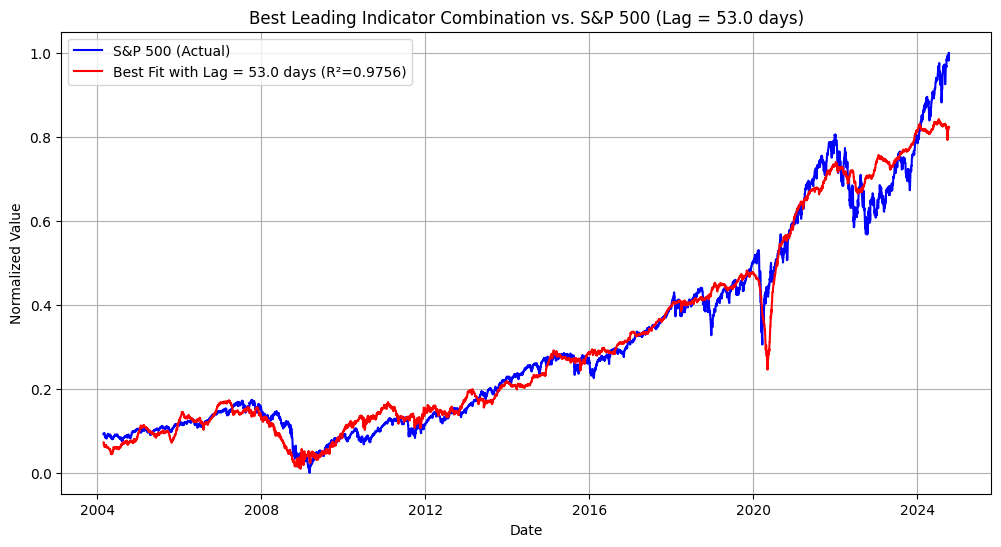

In [137]:
#Find the Best Lag

# Normalize the combined data (S&P 500 and economic indicators)
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns, index=combined_data.index)

# Extract the normalized S&P 500 separately
normalized_snp = normalized_data['S&P500']

# Define the specific combination of variables (for example, you can select a subset of variables)
selected_combination = normalized_data.drop(columns=['S&P500']).columns.tolist()  # All variables except S&P 500

# Function to evaluate the fit of a given lag
def evaluate_lag(X_lagged, y_lagged):
    # Create regression model
    model = LinearRegression()

    # Train the model and evaluate
    model.fit(X_lagged, y_lagged)
    y_pred = model.predict(X_lagged)

    # Calculate R-squared and MSE
    r2 = r2_score(y_lagged, y_pred)
    mse = mean_squared_error(y_lagged, y_pred)

    return r2, mse, y_pred

# Sensitivity analysis for different lags
lags = range(5, 61)  # Define the different lag periods to test (from 5 to 60 days)
lag_results = []

# Iterate through different lags
for lag in lags:
    
    # Lag the independent variables to create leading indicators
    X_lagged = normalized_data[selected_combination].shift(lag).dropna()  # Lag the variables by the given period
    
    # Align S&P 500 with lagged variables
    y_lagged = normalized_snp.loc[X_lagged.index]
    
    # Evaluate the lag
    r2, mse, _ = evaluate_lag(X_lagged, y_lagged)
    
    # Store the results
    lag_results.append((lag, r2, mse))

# Convert results to DataFrame
lag_results_df = pd.DataFrame(lag_results, columns=['Lag', 'R²', 'MSE'])
lag_results_df.sort_values(by='R²', ascending=False, inplace=True)

# Print the best results for different lags
print("\nTop combinations tested across all lags:")
print(lag_results_df)

# Identify the optimal lag
optimal_lag = lag_results_df.iloc[0]['Lag']
optimal_r2 = lag_results_df.iloc[0]['R²']
optimal_mse = lag_results_df.iloc[0]['MSE']

print(f"\nOptimal Lag: {optimal_lag} days with R²: {optimal_r2:.4f} and MSE: {optimal_mse:.4f}")

# Create a DataFrame for the best lag predictions
X_best_lagged = normalized_data[selected_combination].shift(int(optimal_lag)).dropna()
y_best_lagged = normalized_snp.loc[X_best_lagged.index]

# Evaluate the best combination for this lag
_, _, best_pred = evaluate_lag(X_best_lagged, y_best_lagged)

# Create a DataFrame to hold the best lag results
best_lag_df = pd.DataFrame(best_pred, index=y_best_lagged.index, columns=[f'Optimal Lag = {optimal_lag}'])

# --- Plotting the best lag ---
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_best_lagged.index, y_best_lagged, label='S&P 500 (Actual)', color='blue')
plt.plot(best_lag_df.index, best_lag_df, label=f'Best Fit with Lag = {optimal_lag} days (R²={optimal_r2:.4f})', color='red')

plt.title(f'Best Leading Indicator Combination vs. S&P 500 (Lag = {optimal_lag} days)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()


In [138]:
# Rename the column in best_lag_df
best_lag_df.rename(columns={'Optimal Lag = 53.0': 'Optimal Lag'}, inplace=True)
best_lag_df.head()

,Optimal Lag = 53.0
2004-02-27,0.072064
2004-02-28,0.069914
2004-02-29,0.070199
2004-03-01,0.070420
2004-03-02,0.065844


In [139]:
## Add a lag to the DF
df_lagged = best_lag_df.shift(-46)

#Align Lagged DF with SnP
aligned_lagged_df = df_lagged.reindex(normalized_snp.index)


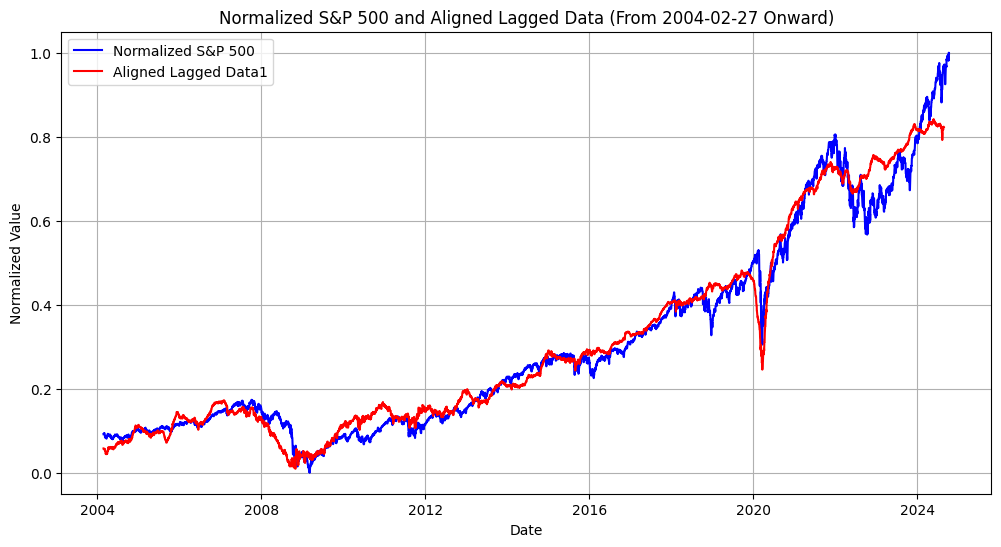

In [140]:
# Filter the data from 2004-02-27 onward
start_date = '2004-02-27'
filtered_snp_data = normalized_snp.loc[start_date:]
filtered_lagged_df = aligned_lagged_df.loc[start_date:]


# Plot the normalized S&P 500 data and the aligned lagged data
plt.figure(figsize=(12, 6))

# Plot normalized S&P 500 data
plt.plot(filtered_snp_data.index, filtered_snp_data, label='Normalized S&P 500', color='blue')

# Plot the aligned lagged DataFrame
plt.plot(filtered_lagged_df.index, filtered_lagged_df, label='Aligned Lagged Data1', color='red')


# Add titles, labels, and grid
plt.title('Normalized S&P 500 and Aligned Lagged Data (From 2004-02-27 Onward)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

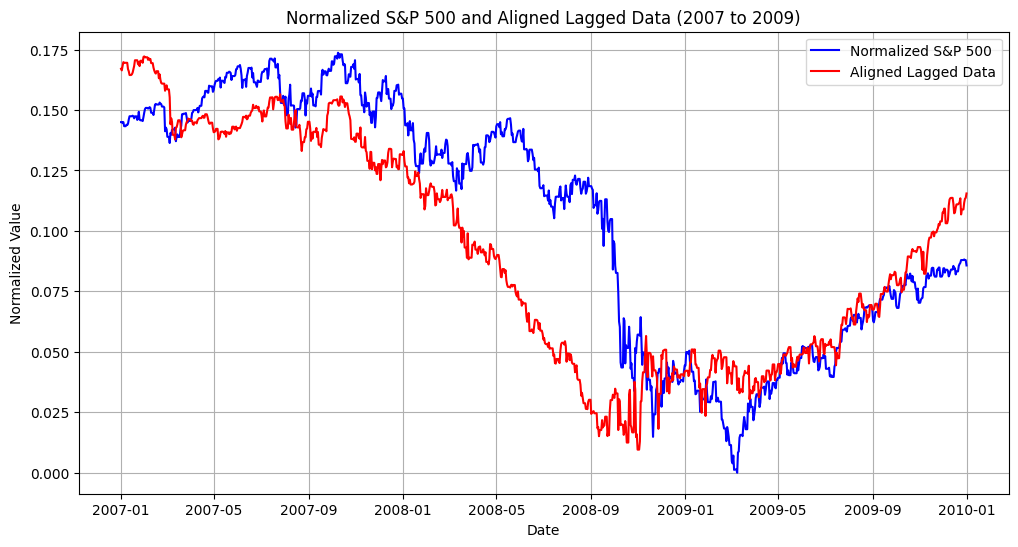

In [141]:
# Filter the data between 2007 and 2009
start = '2007-01-01'
end = '2009-12-31'
filtered_snp_data = normalized_snp.loc[start:end]
filtered_lagged_df = aligned_lagged_df.loc[start:end]

# Plot the normalized S&P 500 data and the aligned lagged data
plt.figure(figsize=(12, 6))

# Plot normalized S&P 500 data
plt.plot(filtered_snp_data.index, filtered_snp_data, label='Normalized S&P 500', color='blue')

# Plot the aligned lagged DataFrame
plt.plot(filtered_lagged_df.index, filtered_lagged_df, label='Aligned Lagged Data', color='red')

# Add titles, labels, and grid
plt.title('Normalized S&P 500 and Aligned Lagged Data (2007 to 2009)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

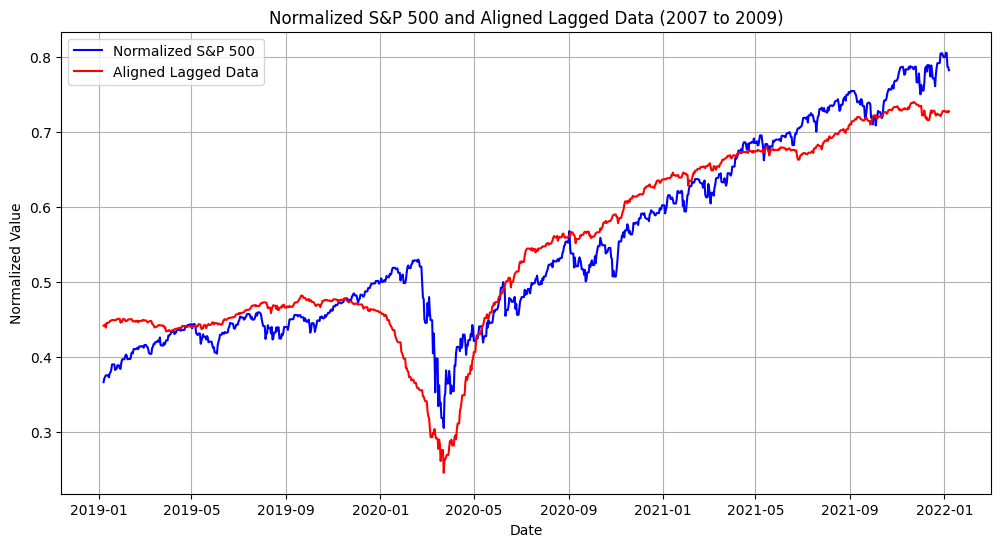

In [142]:
# Filter the data between 2007 and 2009
start = '2019-01-07'
end = '2022-01-07'
filtered_snp_data = normalized_snp.loc[start:end]
filtered_lagged_df = aligned_lagged_df.loc[start:end]

# Plot the normalized S&P 500 data and the aligned lagged data
plt.figure(figsize=(12, 6))

# Plot normalized S&P 500 data
plt.plot(filtered_snp_data.index, filtered_snp_data, label='Normalized S&P 500', color='blue')

# Plot the aligned lagged DataFrame
plt.plot(filtered_lagged_df.index, filtered_lagged_df, label='Aligned Lagged Data', color='red')

# Add titles, labels, and grid
plt.title('Normalized S&P 500 and Aligned Lagged Data (2007 to 2009)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

When working with financial data, especially for predicting time series like the S&P 500, there are several models you can explore beyond **Linear Regression**. Each model has different strengths, and the choice of the model depends on the structure of the data and the specific goals of the analysis.

Here are some commonly used models for financial time series forecasting:

### 1. **Random Forest Regressor**
- **Type**: Ensemble Learning (Tree-based)
- **Strengths**: 
   - Handles non-linear relationships well.
   - Not sensitive to overfitting if properly tuned.
   - Handles missing data and outliers better than many other models.
- **Weaknesses**: Can be computationally expensive for large datasets.
  ```python
  from sklearn.ensemble import RandomForestRegressor
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  ```

### 2. **Gradient Boosting Machines (GBM)**
   - **Type**: Ensemble Learning
   - **Strengths**:
     - Powerful for time series forecasting and regression tasks.
     - Focuses on correcting errors from previous models (boosting approach).
     - Highly flexible with hyperparameters like learning rate, number of estimators.
   - **Models**: `XGBoost`, `LightGBM`, `CatBoost`
   - **Popular for Financial Data**: `XGBoost` and `LightGBM` are widely used in financial applications due to their robustness and performance on large datasets.

   ```python
   from xgboost import XGBRegressor
   model = XGBRegressor(n_estimators=100, learning_rate=0.1)
   ```

### 3. **Support Vector Regressor (SVR)**
   - **Type**: Kernel-based regression
   - **Strengths**:
     - Handles non-linearity through the use of kernel functions.
     - Good for datasets with a lot of noise and high dimensionality.
   - **Weaknesses**: Can be slow to train on large datasets.

   ```python
   from sklearn.svm import SVR
   model = SVR(kernel='rbf')
   ```

### 4. **Neural Networks (Deep Learning)**
   - **Type**: Neural Networks
   - **Strengths**:
     - Flexible and powerful for capturing non-linear relationships in data.
     - Can model complex interactions between variables.
   - **Weaknesses**:
     - Requires a large dataset for training.
     - Prone to overfitting without proper tuning and regularization.
   - **Models**: 
     - `LSTM` (Long Short-Term Memory): Works well with time series due to memory units.
     - `GRU` (Gated Recurrent Units): A simplified variant of LSTM.
     - Fully connected `Dense` layers for simpler regressions.

   ```python
   from keras.models import Sequential
   from keras.layers import LSTM, Dense
   
   model = Sequential()
   model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
   model.add(LSTM(units=50))
   model.add(Dense(1))  # Single output for regression
   ```

### 5. **ARIMA / SARIMA / ARIMAX**
   - **Type**: Traditional Time Series Model
   - **Strengths**:
     - Specifically designed for time series forecasting.
     - ARIMAX can handle external variables (exogenous factors) like commodity prices.
   - **Weaknesses**:
     - Works well with stationary data; need to transform non-stationary data.
     - Limited in capturing non-linear relationships.
   
   ```python
   from statsmodels.tsa.statespace.sarimax import SARIMAX
   model = SARIMAX(endog=y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
   ```

### 6. **Ridge / Lasso Regression**
   - **Type**: Regularized Linear Regression
   - **Strengths**:
     - Ridge adds L2 regularization (good for small datasets).
     - Lasso adds L1 regularization, which can help with feature selection by penalizing non-informative features.
   - **Weaknesses**: Assumes linear relationships between features and target.

   ```python
   from sklearn.linear_model import Ridge, Lasso
   model = Ridge(alpha=1.0)  # Ridge
   model = Lasso(alpha=0.1)  # Lasso
   ```

### 7. **K-Nearest Neighbors (KNN) Regressor**
   - **Type**: Instance-based Learning
   - **Strengths**:
     - Simple and intuitive.
     - Good for small datasets and non-linear relationships.
   - **Weaknesses**: 
     - Sensitive to noise and scaling.
     - Not great for large, high-dimensional datasets.

   ```python
   from sklearn.neighbors import KNeighborsRegressor
   model = KNeighborsRegressor(n_neighbors=5)
   ```

### 8. **Elastic Net**
   - **Type**: Regularized Linear Regression (combines Lasso and Ridge)
   - **Strengths**:
     - Handles feature selection and multicollinearity better than standard linear regression.
     - Balances between Lasso and Ridge regularization.
   - **Weaknesses**: Same limitations as other linear models if the relationship is highly non-linear.

   ```python
   from sklearn.linear_model import ElasticNet
   model = ElasticNet(alpha=1.0, l1_ratio=0.5)
   ```

---

### Choosing the Best Model for Financial Data:
- **Ensemble methods** (Random Forest, Gradient Boosting like XGBoost or LightGBM) are often a strong choice for financial data due to their ability to handle non-linear relationships and their robustness.
- **LSTM/GRU** networks excel for sequential and time series forecasting but require more data and careful tuning.
- **ARIMA/SARIMA** is effective for purely time series data with seasonality and trend but may underperform with external factors.
- **Support Vector Regression (SVR)** and **Neural Networks** are more powerful for capturing complex relationships but require more computational resources.

## **PART II**

To analyze which economic and commodity variables are most relevant for explaining the variance in the S&P 500, we can perform PCA on the features (the economic indicators and commodity prices) while using the S&P 500 as the target variable for understanding how much of its variance can be explained by these features. 

### Applying PCA on the Dataset

In [143]:
# Using Original Dataset
features_for_pca = data_no_snp #combined_data

# Drop any remaining NaNs (if there are any)
features_for_pca.dropna(inplace=True)

# --- Normalize the data ---
# Use StandardScaler to scale the data (this is necessary for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_for_pca)

# --- Perform PCA ---
pca = PCA(n_components=0.95)  # Keep 95% of variance
principal_components = pca.fit_transform(scaled_data)

# --- Create a DataFrame of principal components ---
pca_df = pd.DataFrame(principal_components, index=features_for_pca.index)

# --- Print the explained variance ratios ---
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained variance ratio of each principal component: {explained_variance_ratio}')

# --- Calculate the contribution of each original variable to the variance explained ---
# Get the PCA components and corresponding feature names
pca_components = pca.components_
features = features_for_pca.columns

# Create a DataFrame to show the contribution of each feature to the principal components
contribution_df = pd.DataFrame(pca_components.T, index=features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Calculate the explained variance for each feature
explained_variance = np.abs(contribution_df) * explained_variance_ratio  # Absolute contributions multiplied by variance
explained_variance_percentage = explained_variance.div(explained_variance.sum(axis=0), axis=1) * 100  # Convert to percentage

Explained variance ratio of each principal component: [0.44363372 0.2112131  0.1361876  0.09879481 0.04829045 0.03159868]


In [144]:
# Create a DataFrame for contribution percentages without duplicates
contribution_df = pd.DataFrame(explained_variance_percentage, index=features).T
contribution_df = contribution_df.loc[:, ~contribution_df.columns.duplicated()]  # Remove duplicates

# Print the clean table
print("Percentage of S&P 500 variance explained by each variable:")
contribution_df

Percentage of S&P 500 variance explained by each variable:


,M1,M2,Interest_Rate,Inflation,Unemployment_Rate,Manufacturing_Production,Copper,Gold,Oil,NG,VIX,Global_GDP_Growth,Mortgage_Rate
PC1,11.236985,12.719884,5.575898,12.778691,4.530796,7.324290,8.416688,12.051638,1.997119,7.072816,0.576061,12.707015,3.012119
PC2,2.457784,0.044654,16.500284,1.852724,14.263373,11.493265,3.319264,4.523087,6.098259,11.575404,8.536630,2.675825,16.659446
PC3,2.490586,2.070815,4.384265,0.286433,14.482506,8.383969,15.545449,6.230678,20.137486,7.032880,11.087600,2.079195,5.788139
PC4,10.053872,5.699963,7.297940,4.265814,0.423416,10.850713,9.081523,1.335532,13.433664,2.480869,18.159018,5.116119,11.801558
PC5,2.074771,2.014432,12.361532,2.554251,10.035652,10.442762,2.505627,5.022153,4.635052,19.260029,16.811499,1.648339,10.633900
PC6,16.953770,5.566141,2.533894,2.737791,5.742158,12.223514,2.433445,2.369613,5.811502,18.067275,17.923940,0.685021,6.951937


Top contributors to PC1:
Inflation            0.404585
M2                   0.402723
Global_GDP_Growth    0.402316
Name: PC1, dtype: float64


Top contributors to PC2:
Mortgage_Rate        0.485490
Interest_Rate        0.480852
Unemployment_Rate    0.415663
Name: PC2, dtype: float64


Top contributors to PC3:
Oil                  0.579859
Copper               0.447631
Unemployment_Rate    0.417024
Name: PC3, dtype: float64




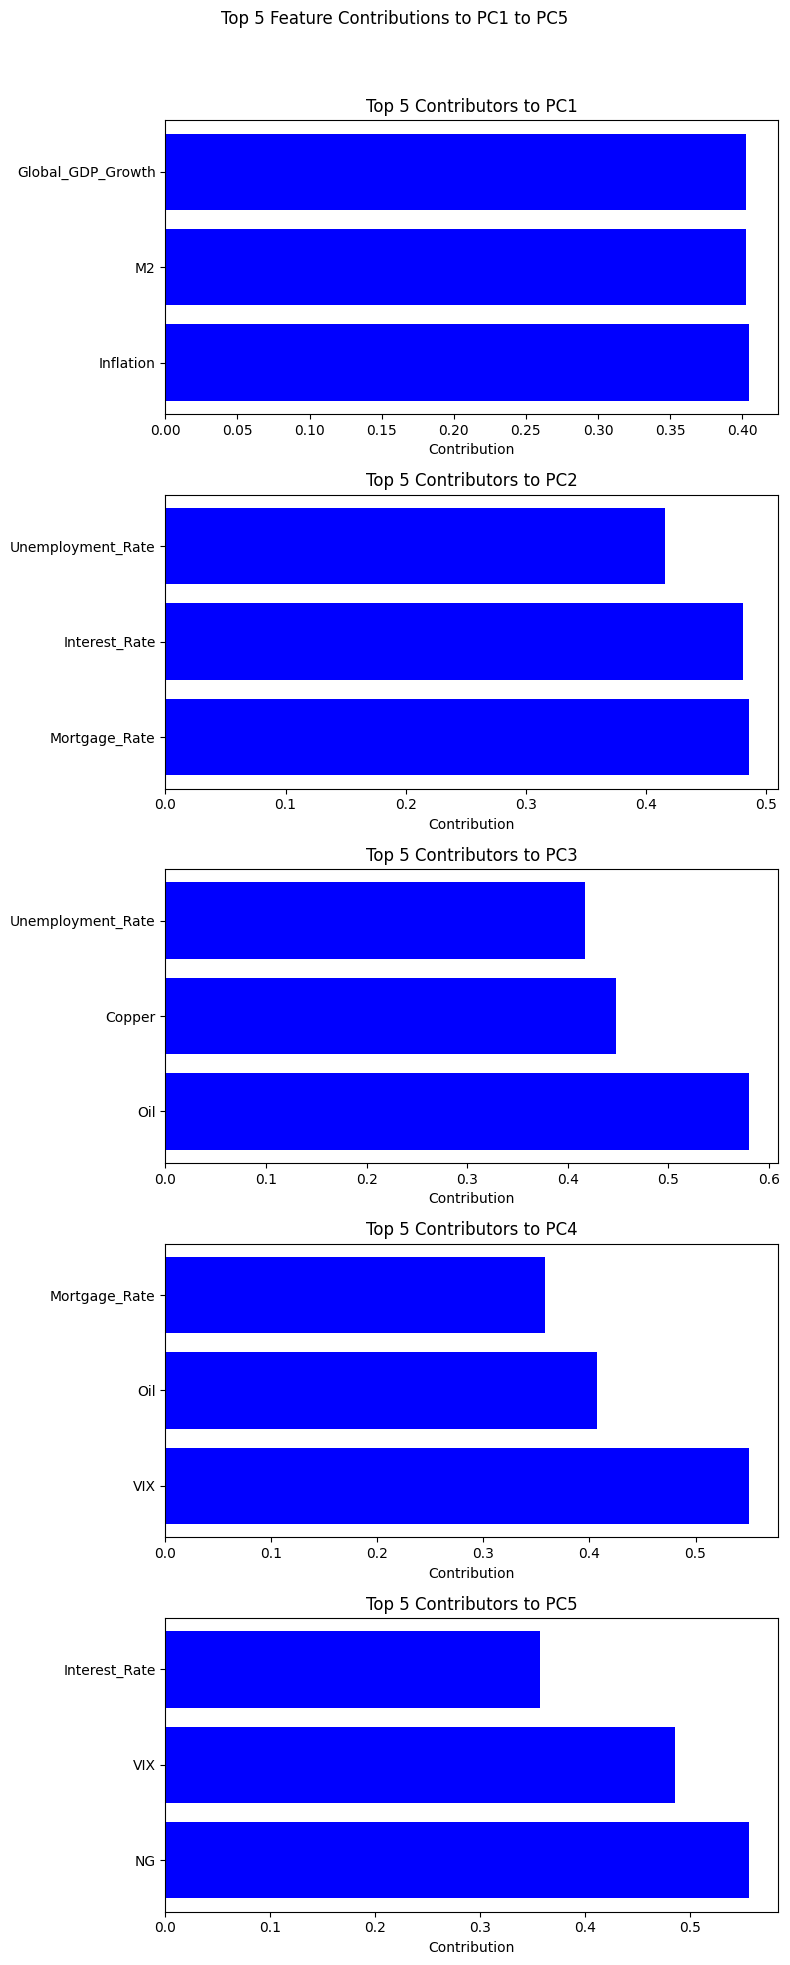

Explained variance ratio of each principal component: [0.44363372 0.2112131  0.1361876  0.09879481 0.04829045 0.03159868]


In [145]:
# --- Normalize the data ---
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_for_pca)

# --- Perform PCA ---
pca = PCA(n_components=0.95)  # Keep 95% of variance
principal_components = pca.fit_transform(scaled_data)

# --- Create a DataFrame of principal components ---
pca_df = pd.DataFrame(principal_components, index=features_for_pca.index)

# --- Get the PCA components and corresponding feature names ---
pca_components = pca.components_
features = features_for_pca.columns

# Create a DataFrame to show the contribution of each feature to the principal components
contribution_df = pd.DataFrame(pca_components.T, index=features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# --- Get the top contributing features for each PC (PC1 to PC10) ---
def get_top_contributors(contribution_df, pc_num, top_n=3):
    return contribution_df[f'PC{pc_num}'].abs().nlargest(top_n)

# Display the top contributors for PC1 to PC5
for i in range(1, 4):
    top_contributors = get_top_contributors(contribution_df, i)
    print(f"Top contributors to PC{i}:")
    print(top_contributors)
    print("\n")

# --- Create a plot for the contribution of top features ---
fig, axes = plt.subplots(5, 1, figsize=(8, 20))
fig.suptitle("Top 5 Feature Contributions to PC1 to PC5")

for i in range(1, 6):
    top_contributors = get_top_contributors(contribution_df, i)
    axes[i-1].barh(top_contributors.index, top_contributors.values, color='b')
    axes[i-1].set_title(f'Top 5 Contributors to PC{i}')
    axes[i-1].set_xlabel('Contribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Explained variance of each principal component ---
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained variance ratio of each principal component: {explained_variance_ratio}')

# Create a DataFrame for explained variance
explained_variance_df = pd.DataFrame(explained_variance_ratio[:5], index=[f'PC{i}' for i in range(1, 6)], columns=['Explained Variance'])

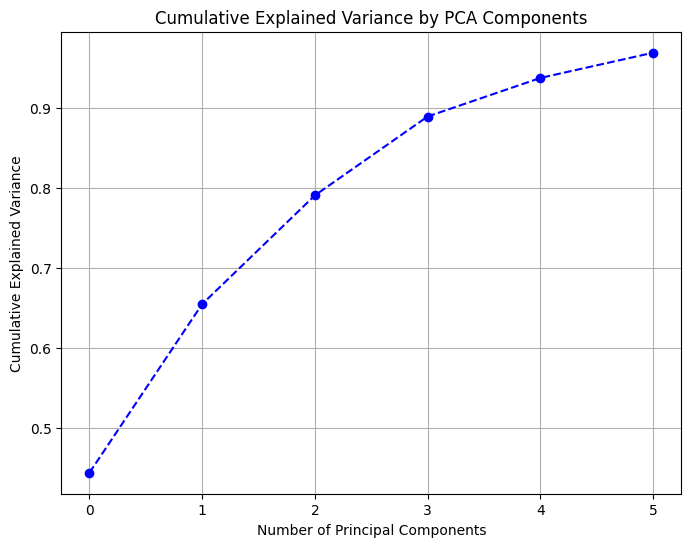

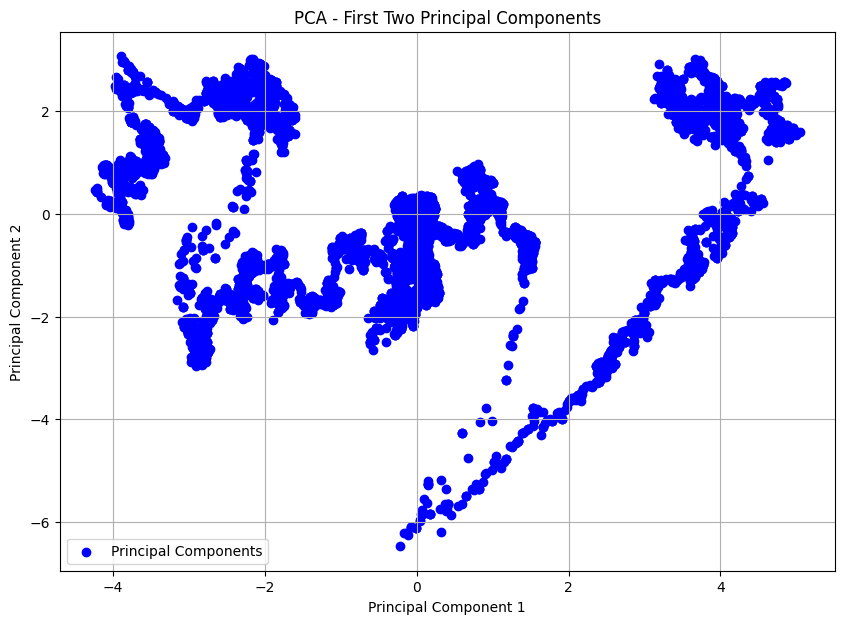

In [146]:
# --- Plot explained variance ---
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# --- Scatter plot of the first two principal components ---
plt.figure(figsize=(10, 7))
plt.scatter(pca_df[0], pca_df[1], c='blue', label='Principal Components')
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [147]:
# Create a DataFrame for contribution percentages without duplicates
contribution_df = pd.DataFrame(explained_variance_percentage, index=features).T
contribution_df = contribution_df.loc[:, ~contribution_df.columns.duplicated()]  # Remove duplicates

# Print the clean table
print("Percentage of S&P 500 variance explained by each variable:")
contribution_df

Percentage of S&P 500 variance explained by each variable:


,M1,M2,Interest_Rate,Inflation,Unemployment_Rate,Manufacturing_Production,Copper,Gold,Oil,NG,VIX,Global_GDP_Growth,Mortgage_Rate
PC1,11.236985,12.719884,5.575898,12.778691,4.530796,7.324290,8.416688,12.051638,1.997119,7.072816,0.576061,12.707015,3.012119
PC2,2.457784,0.044654,16.500284,1.852724,14.263373,11.493265,3.319264,4.523087,6.098259,11.575404,8.536630,2.675825,16.659446
PC3,2.490586,2.070815,4.384265,0.286433,14.482506,8.383969,15.545449,6.230678,20.137486,7.032880,11.087600,2.079195,5.788139
PC4,10.053872,5.699963,7.297940,4.265814,0.423416,10.850713,9.081523,1.335532,13.433664,2.480869,18.159018,5.116119,11.801558
PC5,2.074771,2.014432,12.361532,2.554251,10.035652,10.442762,2.505627,5.022153,4.635052,19.260029,16.811499,1.648339,10.633900
PC6,16.953770,5.566141,2.533894,2.737791,5.742158,12.223514,2.433445,2.369613,5.811502,18.067275,17.923940,0.685021,6.951937


Interpreting the rows of a PCA results table, especially for the rows labeled **PC1**, **PC2**, etc., involves understanding what each principal component represents and how they relate to the original variables in your dataset. Here's a breakdown of how to interpret these components:

### 1. Principal Components (PC1, PC2, ...)

- **Definition**: Principal components are new variables that are linear combinations of the original variables. They are derived from the covariance matrix of the original dataset and represent directions in which the data varies the most.

- **Order of Importance**: The components are ordered by the amount of variance they explain. For example:
  - **PC1** explains the largest amount of variance in the data.
  - **PC2** explains the second-largest amount of variance, orthogonal to PC1.
  - **PC3** explains the third-largest amount of variance, and so on.

### 2. Loading Scores

- Each entry in the PCA results associated with a principal component (e.g., `0.261436` for `Copper` in **PC1**) is known as a **loading score**. The loading score indicates the contribution of each original variable to that principal component.

#### **How to Interpret Loading Scores**:

- **Magnitude**: A higher absolute value of a loading score means that the variable has a stronger influence on that principal component. For example:
  - If **PC1** has a loading score of `0.5` for `M1`, it suggests that `M1` is significantly contributing to the variation captured by **PC1**.

- **Direction**: The sign of the loading score indicates the direction of the relationship:
  - **Positive loading**: The variable positively contributes to the component. Higher values of the variable lead to higher values of the component.
  - **Negative loading**: The variable negatively contributes to the component. Higher values of the variable lead to lower values of the component.

### 3. Explained Variance Ratio

- Alongside loading scores, the **explained variance ratio** tells you how much of the total variance in the dataset is captured by each principal component:
  - For instance, if **PC1** has an explained variance ratio of `0.55`, it means that this component explains **55%** of the total variance in the data.
  
### 4. Contribution to Variance in S&P 500

- If you are analyzing how much each original variable contributes to explaining the variance in the S&P 500:
  - You can look at the loading scores for each variable in relation to the components. The variables with the highest absolute loading scores in the first few components are likely to have a significant influence on the variance of the S&P 500.
  - If you see a variable with a high loading in **PC1** and **PC2**, it may be a crucial predictor for changes in the S&P 500.

### Example Interpretation:
Let’s say your PCA results are as follows:

| Variable               | PC1    | PC2    |
|------------------------|--------|--------|
| **Copper**             | 0.45   | -0.10  |
| **Gold**               | 0.30   | 0.50   |
| **Oil**                | -0.20  | 0.20   |
| **M1**                 | 0.60   | -0.40  |
| **Interest Rate**      | -0.10  | 0.30   |

#### **Interpretation**:

- **PC1**:
  - `M1` has the highest positive loading, indicating it contributes significantly to the first principal component, which captures a large portion of the variance.
  - `Copper` and `Gold` also have positive loadings, suggesting they are positively related to the variation in this component.
  - `Oil` has a negative loading, indicating it is inversely related to this component.

- **PC2**:
  - `Gold` has a high positive loading, suggesting it varies positively with the second principal component.
  - `M1` has a negative loading, indicating an inverse relationship with the variance captured by this component.
  
Analyzing the loadings of each variable on the principal components helps identify which variables have the most substantial impact on the variations observed in the S&P 500. By focusing on the principal components that explain the most variance, you can determine which original variables to emphasize in further analysis or forecasting efforts.

When considering commodities for forecasting the S&P 500 and analyzing their variance contributions, it's important to include those that are typically correlated with economic activity, inflation, and market sentiment. Here are some commodities that are commonly regarded as significant:

### 1. **Natural Gas**
   - **Importance**: Natural gas prices can significantly affect energy costs and are often tied to industrial production and heating demand.

### 2. **Wheat**
   - **Importance**: Agricultural commodities like wheat can reflect food price inflation and supply chain disruptions. They can also indicate broader economic trends related to agriculture and trade.

### 3. **Soybeans**
   - **Importance**: As a major agricultural product, soybean prices can be tied to economic conditions in agricultural economies and global demand for food.

### 4. **Corn**
   - **Importance**: Similar to soybeans and wheat, corn prices can indicate food inflation and agricultural market conditions.

### 5. **Coffee**
   - **Importance**: Coffee prices can be influenced by changes in consumer demand and supply chain issues, providing insights into consumer spending behavior.

### 6. **Aluminum**
   - **Importance**: As a major industrial metal, aluminum prices can reflect manufacturing activity and are sensitive to changes in global trade policies.

### 7. **Nickel and Copper**
   - **Importance**: These base metals are often used as indicators of industrial production and economic health. Their prices can be volatile, reflecting changes in demand from various sectors.

### 8. **Cotton**
   - **Importance**: Cotton prices can serve as an indicator of textile and apparel market conditions, which are sensitive to consumer spending trends.

### 9. **Silver**
   - **Importance**: Silver is an industrial metal used in electronics, solar panels, and other technologies. Its price movements can reflect both investor sentiment and industrial demand.

### 10. **Sugar**
   - **Importance**: Sugar prices can indicate shifts in consumer preferences and are tied to food inflation trends.